#to-do's

- use FPL api to grab data directly, so data is always current
- make predictions on upcoming fixtures
- import my team to make transfer predictions for my current team
- clean cells, features, and variables that are no longer in use

In [1]:
import pandas as pd
from scipy.special import boxcox, inv_boxcox
from scipy import stats
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from glob import glob
import math
import pickle
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import requests
sns.set()

In [2]:
## need at least Pandas 1.1.0 to use the forward-looking indexer later on
pd.__version__

'1.1.3'

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

# import & prep df from 538

In [4]:
spi_url = 'https://projects.fivethirtyeight.com/soccer-api/club/spi_matches.csv'
spi = pd.read_csv(spi_url)

In [5]:
spi = spi[spi['league'] == 'Barclays Premier League']

In [6]:
# the spi dataset includes one row for every game -- I need one row, per team, per game
spi2 = spi 

In [7]:
spi = spi.rename(columns={'team1':'team', 'team2': 'team_opp', 'spi1': 'spi', 'spi2': 'spi_opp', 'proj_score1': 'proj_score', 'proj_score2': 'proj_score_opp', 'prob1': 'prob_w', 'prob2': 'prob_l', 'importance1': 'importance', 'importance2': 'importance_opp'})

In [8]:
spi2 = spi2.rename(columns={'team2':'team', 'team1': 'team_opp', 'spi2': 'spi', 'spi1': 'spi_opp', 'proj_score2': 'proj_score', 'proj_score1': 'proj_score_opp', 'prob2': 'prob_w', 'prob1': 'prob_l', 'importance2': 'importance', 'importance1': 'importance_opp'})

In [9]:
spi = spi.append(spi2, sort = True)

In [10]:
spi = spi[['date', 'team', 'team_opp', 'spi', 'spi_opp', 'proj_score', 'proj_score_opp', 'prob_w', 'prob_l', 'probtie', 'importance', 'importance_opp']]

# import and append fantasy performance data

In [11]:
#look at what columns are available

years = [('2018-19', 'ISO-8859-1'), ('2019-20', 'utf-8')]
# later realized that the 2018-19 CSV is not encoded in UTF-8, so made the above into tuples including the explicit encoding
for year, encoding in years:
    #import player-level data
    section = 'data/'+year+'/gws/merged_gw.csv'
    section = pd.read_csv(section, engine='python', encoding=encoding)
    print(year)
    print(list(section))

2018-19
['name', 'assists', 'attempted_passes', 'big_chances_created', 'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'clearances_blocks_interceptions', 'completed_passes', 'creativity', 'dribbles', 'ea_index', 'element', 'errors_leading_to_goal', 'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded', 'goals_scored', 'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time', 'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded', 'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round', 'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'winning_goals', 'yellow_cards', 'GW']
2019-20
['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index

# Merge data where it's not already merged

I had to change the column names in 2018-19 teams.csv to make a column called "Team", to correspond with other seasons

In [12]:
# I spent a long time cleaning & concatenating data from different seasons until I stumbled upon this:
# https://github.com/solpaul/fpl-prediction/blob/master/data/train_v5.csv
# thanks solpaul!

# the only thing this dataset is missing is player value on fpl, but from previous analyis, player value wasn't
# an effictive predicting feature, so I'm not worried about it for now. Can always merge it later

solpaul_data = 'https://raw.githubusercontent.com/solpaul/fpl-prediction/master/data/train_v5.csv'
players = pd.read_csv(solpaul_data, index_col = 0)

In [13]:
players.head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,relative_market_value_team_season,relative_market_value_opponent_team_season
0,Aaron_Cresswell,1,2,0,West Ham United,Chelsea,NaN,NaN,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,14023,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,0.895471,2.243698
1,Aaron_Lennon,1,3,15,Everton,Tottenham Hotspur,NaN,NaN,True,1,0,0,6,0,0.3,0,0,0.9,8.2,0,0,0,0,0,13918,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,1.057509,1.433690
2,Aaron_Ramsey,1,3,60,Arsenal,Liverpool,NaN,NaN,True,2,0,0,5,0,4.9,3,0,3.0,2.2,0,0,0,0,0,163170,4,3,23.0,0,0,0,0,2016-08-14T15:00:00Z,1617,NaN,1.944129,1.465860
3,Abdoulaye_Doucouré,1,3,0,Watford,Southampton,NaN,NaN,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1051,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,0.704200,0.796805
4,Abdul Rahman_Baba,1,2,0,Chelsea,West Ham United,NaN,NaN,True,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1243,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,2.243698,0.895471


In [14]:
# Most recent data:
most_recent = players.sort_values('kickoff_time').kickoff_time.unique()[-1]
most_recent

'2020-11-08T19:15:00Z'

In [15]:
players.describe()

,gw,position,minutes,relative_market_value_team,relative_market_value_opponent_team,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,season,play_proba,relative_market_value_team_season,relative_market_value_opponent_team_season
count,94888.000000,94888.000000,94888.000000,26825.000000,26802.000000,94888.000000,94888.000000,94888.000000,94888.000000,94888.000000,94888.000000,94888.000000,94888.000000,94888.000000,94888.000000,94888.000000,94888.000000,94888.000000,94888.000000,94888.000000,9.488800e+04,94888.000000,94888.000000,94888.000000,9.488800e+04,9.488800e+04,9.488800e+04,94888.000000,94888.000000,26160.000000,90862.000000,90862.000000
mean,19.547119,2.593668,33.229207,0.997989,1.002125,1.381112,0.040975,0.107664,6.248156,0.106842,4.969762,0.513901,0.045243,1.795376,7.483022,0.001475,0.001001,0.000801,0.001918,0.097684,1.463815e+05,1.220534,1.551029,5.514206,4.409326e+02,9.521764e+03,9.080191e+03,0.055803,1778.103132,0.777456,0.991635,0.999974
std,11.273880,0.859528,40.808796,0.695762,0.710019,2.526350,0.215698,0.489761,9.945249,0.308914,10.999099,0.981838,0.233394,3.111070,13.114030,0.038383,0.031626,0.029025,0.043754,0.639060,3.408479e+05,1.210092,1.306646,13.781208,4.266884e+04,3.682179e+04,3.174314e+04,0.229541,123.525152,0.404338,0.693254,0.704822
min,1.000000,1.000000,0.000000,0.150592,0.150592,-6.000000,0.000000,0.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-1.309566e+06,0.000000e+00,0.000000e+00,0.000000,1617.000000,0.000000,0.150631,0.150631
25%,9.000000,2.000000,0.000000,0.472917,0.471059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.532000e+03,0.000000,1.000000,0.000000,-1.262000e+03,4.000000e+01,1.220000e+02,0.000000,1718.000000,0.750000,0.452793,0.452793
50%,20.000000,3.000000,0.000000,0.707921,0.707129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.380400e+04,1.000000,1.000000,0.000000,-7.400000e+01,3.280000e+02,9.070000e+02,0.000000,1819.000000,1.000000,0.704200,0.704200
75%,30.000000,3.000000,90.000000,1.500845,1.544507,2.000000,0.000000,0.000000,11.000000,0.000000,3.100000,1.000000,0.000000,2.600000,11.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1.176278e+05,2.000000,2.000000,2.000000,3.200000e+01,3.426000e+03,5.723000e+03,0.000000,1920.000000,1.000000,1.465860,1.465860
max,38.000000,4.000000,90.000000,2.748793,2.748793,29.000000,4.000000,3.000000,114.000000,1.000000,170.900000,9.000000,4.000000,35.800000,163.600000,1.000000,1.000000,2.000000,1.000000,14.000000,4.481515e+06,9.000000,8.000000,199.000000,1.907229e+06,1.991731e+06,1.382044e+06,1.000000,2021.000000,1.000000,2.727025,2.727025


In [16]:
# profile = ProfileReport(players, title="Pandas Profiling Report")
# profile.to_widgets()

In [17]:
list(players)

['player',
 'gw',
 'position',
 'minutes',
 'team',
 'opponent_team',
 'relative_market_value_team',
 'relative_market_value_opponent_team',
 'was_home',
 'total_points',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'own_goals',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'yellow_cards',
 'kickoff_time',
 'season',
 'play_proba',
 'relative_market_value_team_season',
 'relative_market_value_opponent_team_season']

In [18]:
keep_cols = ['player',
 'gw',
 'position',
 'minutes',
 'team',
 'opponent_team',
 'was_home',
 'total_points',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'yellow_cards',
 'kickoff_time',
 'season']

In [19]:
# getting rid of columns that have a high level of missing values
# I'll use the 538 data to assess team quality, so I'm not worried about losing team-level features
players = players[keep_cols]

In [20]:
update_data = 'https://github.com/vaastav/Fantasy-Premier-League/raw/master/data/2020-21/gws/merged_gw.csv'
update_data = pd.read_csv(update_data)

In [21]:
update_data = update_data[update_data['kickoff_time'] > most_recent]

In [22]:
for x in keep_cols:
    if x not in list(update_data):
        print(x)

player
gw
season


In [23]:
update_data = update_data.rename(columns={'name': 'player',
                                'GW': 'gw'})

In [24]:
update_data['season'] = 1920

In [25]:
team_ids = 'https://raw.githubusercontent.com/solpaul/fpl-prediction/master/data/teams.csv'
team_ids = pd.read_csv(team_ids)

In [26]:
team_ids = team_ids[['team_2021', 'team']].to_dict(orient='split')['data']
team_ids = dict(team_ids)

In [27]:
update_data['opponent_team'] = update_data['opponent_team'].replace(team_ids)

In [28]:
players = players.append(update_data, ignore_index=True, sort=False)

In [29]:
players['date'] = pd.to_datetime(players['kickoff_time'])
players['date'] = players['date'].dt.strftime('%Y-%m-%d')

In [30]:
players = players.rename(columns={'player': 'name'})

In [31]:
#the players data has some underscores in player names, the update data does not
players['name'] = players.name.str.replace('_', ' ')

In [32]:
for x in list(players.team.unique()):
    if x not in list(spi.team.unique()):
        print(x)

Bournemouth
Newcastle United
Wolverhampton Wanderers
Norwich
Leeds
West Ham
Man City
Man Utd
Brighton
Sheffield Utd
West Brom
Leicester
Wolves
Spurs


In [33]:
players.sort_values('team').team.unique()

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton',
       'Brighton and Hove Albion', 'Burnley', 'Cardiff City', 'Chelsea',
       'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield Town',
       'Hull City', 'Leeds', 'Leicester', 'Leicester City', 'Liverpool',
       'Man City', 'Man Utd', 'Manchester City', 'Manchester United',
       'Middlesbrough', 'Newcastle', 'Newcastle United', 'Norwich',
       'Sheffield United', 'Sheffield Utd', 'Southampton', 'Spurs',
       'Stoke City', 'Sunderland', 'Swansea City', 'Tottenham Hotspur',
       'Watford', 'West Brom', 'West Bromwich Albion', 'West Ham',
       'West Ham United', 'Wolverhampton Wanderers', 'Wolves'],
      dtype=object)

In [34]:
players.team = players.team.replace({'Brighton': 'Brighton and Hove Albion',
                                    'West Ham': 'West Ham United',
                                    'Sheffield Utd': 'Sheffield United',
                                    'Man Utd': 'Manchester United',
                                    'Wolves': 'Wolverhampton Wanderers',
                                    'Leicester': 'Leicester City',
                                    'Man City': 'Manchester City',
                                    'West Brom': 'West Bromwich Albion',
                                     'Newcastle': 'Newcastle United',
                                     'Spurs': 'Tottenham Hotspur'
                                    })

In [35]:
spi = spi.replace({'AFC Bournemouth': 'Bournemouth',
                   'Newcastle': 'Newcastle United',
                   'Wolverhampton': 'Wolverhampton Wanderers',
                   'Norwich City': 'Norwich',
                   'Leeds United': 'Leeds'
    })

In [36]:
players = players.merge(spi, how='left', left_on=['date', 'team'], right_on=['date', 'team'])

In [37]:
players.shape

(96092, 48)

In [38]:
players.isnull().sum()

name                     0
gw                       0
position                 0
minutes                  0
team                     0
opponent_team            0
was_home                 0
total_points             0
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
penalties_missed         0
penalties_saved          0
red_cards                0
saves                    0
selected                 0
team_a_score             0
team_h_score             0
threat                   0
transfers_balance        0
transfers_in             0
transfers_out            0
yellow_cards             0
kickoff_time             0
season                   0
xP                   94888
element              94888
fixture              94888
own_goals            94888
round                94888
value                94888
d

Address null rows

In [39]:
players[players.spi.isnull()]

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,xP,element,fixture,own_goals,round,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
90549,Emiliano Martínez,1,1,0,Aston Villa,Fulham,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,292339,3,0,0.0,0,0,0,0,2020-09-12T11:30:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92473,Theo Walcott,4,3,12,Southampton,Brighton and Hove Albion,True,1,0,0,3,0,0.3,1,0,0.1,0.2,0,0,0,0,12620,2,4,0.0,-1656,475,832,0,2020-10-03T14:00:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Emiliano Martinez's data seems to have been messed up, because he started the season with Arsenal, but was traded to Aston Villa. Arsenal's first game of the season was against Fulham, not Aston Villa's

In [40]:
players[(players.name == 'Emiliano Martínez') & (players.gw == 1)]

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,xP,element,fixture,own_goals,round,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
68086,Emiliano Martínez,1,1,0,Arsenal,Newcastle United,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,16175,1,0,0.0,0,0,0,0,2019-08-11T13:00:00Z,1920,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-11,Newcastle United,79.72,70.33,1.65,1.33,0.4471,0.3059,0.2471,47.9,24.2
90549,Emiliano Martínez,1,1,0,Aston Villa,Fulham,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,292339,3,0,0.0,0,0,0,0,2020-09-12T11:30:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
players[(players.name == 'Theo Walcott') & (players.gw == 4) & (players.season == 2021)]

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,xP,element,fixture,own_goals,round,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
92473,Theo Walcott,4,3,12,Southampton,Brighton and Hove Albion,True,1,0,0,3,0,0.3,1,0,0.1,0.2,0,0,0,0,12620,2,4,0.0,-1656,475,832,0,2020-10-03T14:00:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92474,Theo Walcott,4,3,0,Southampton,West Bromwich Albion,True,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,12620,0,2,0.0,-1656,475,832,0,2020-10-04T11:00:00Z,2021,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-04,West Bromwich Albion,71.66,58.44,1.76,0.97,0.5561,0.2039,0.24,26.0,42.8


Walcott was playing for Everton until 10/5 -- this data got messed up for similar reasons to the Martinez issues. Sinc he hardly played, let's just drop both rows.

In [42]:
players = players.drop([90549, 92473, 92474])

In [43]:
# about 2% of the imoprtance values are missing, spread across different teams
players[players.importance.isnull()][['team', 'gw']].groupby('team')['gw'].count()

team
Arsenal                 166
Bournemouth              89
Burnley                 119
Chelsea                 121
Crystal Palace          112
Everton                  88
Hull City               101
Leicester City           85
Liverpool                98
Manchester City         183
Manchester United       125
Middlesbrough            91
Southampton             165
Stoke City              126
Sunderland              145
Swansea City             86
Tottenham Hotspur        89
Watford                 154
West Bromwich Albion    121
West Ham United         100
Name: gw, dtype: int64

In [44]:
# most of these missing values are from early games
players[players.importance.isnull()]['date'].unique()

array(['2016-12-14', '2016-12-13', '2017-01-02', '2017-01-03',
       '2017-01-04', '2017-03-08', '2017-04-05', '2017-04-04',
       '2017-05-10', '2017-05-16', '2017-05-15', '2017-05-17',
       '2020-11-28'], dtype=object)

In [45]:
importance_by_team = players.groupby('team')[['importance', 'importance_opp']].mean().reset_index()

In [46]:
for team in players.team.unique():
    importance_fill = importance_by_team[importance_by_team.team == team]['importance'].values[0]
    importance_opp_fill = importance_by_team[importance_by_team.team == team]['importance_opp'].values[0]
    players.loc[(players.importance.isnull()) & (players.team == team), 'importance'] = importance_fill
    players.loc[(players.importance_opp.isnull()) & (players.team == team), 'importance_opp'] = importance_opp_fill

In [47]:
players.head()

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,xP,element,fixture,own_goals,round,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp
0,Aaron Cresswell,1,2,0,West Ham United,Chelsea,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,14023,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-15,Chelsea,63.27,80.70,0.91,2.23,0.1177,0.6908,0.1915,25.5,67.7
1,Aaron Lennon,1,3,15,Everton,Tottenham Hotspur,True,1,0,0,6,0,0.3,0,0,0.9,8.2,0,0,0,0,13918,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-13,Tottenham Hotspur,68.02,73.25,1.47,1.38,0.3910,0.3401,0.2689,31.9,48.0
2,Aaron Ramsey,1,3,60,Arsenal,Liverpool,True,2,0,0,5,0,4.9,3,0,3.0,2.2,0,0,0,0,163170,4,3,23.0,0,0,0,0,2016-08-14T15:00:00Z,1617,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-14,Liverpool,82.55,77.44,1.91,1.21,0.5551,0.2115,0.2334,62.7,63.9
3,Abdoulaye Doucouré,1,3,0,Watford,Southampton,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,1051,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-13,Southampton,59.33,69.49,1.05,1.91,0.1874,0.5759,0.2367,30.7,34.1
4,Abdul Rahman Baba,1,2,0,Chelsea,West Ham United,True,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,1243,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,NaN,NaN,NaN,NaN,NaN,2016-08-15,West Ham United,80.70,63.27,2.23,0.91,0.6908,0.1177,0.1915,67.7,25.5


In [48]:
# not going to use the 'value' col as a feature,
# but I do want to be able to user later on
#fill with zeroes for the time being
players['value'] = players['value'].fillna(0)

In [49]:
players.isnull().sum()

name                     0
gw                       0
position                 0
minutes                  0
team                     0
opponent_team            0
was_home                 0
total_points             0
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
penalties_missed         0
penalties_saved          0
red_cards                0
saves                    0
selected                 0
team_a_score             0
team_h_score             0
threat                   0
transfers_balance        0
transfers_in             0
transfers_out            0
yellow_cards             0
kickoff_time             0
season                   0
xP                   94885
element              94885
fixture              94885
own_goals            94885
round                94885
value                    0
d

In [50]:
# the other missing values I'm not going to worry about -- not going to use as features
# will drop colums
players = players.dropna(how='any', axis = 1)

In [51]:
players.isnull().sum()

name                 0
gw                   0
position             0
minutes              0
team                 0
opponent_team        0
was_home             0
total_points         0
assists              0
bonus                0
bps                  0
clean_sheets         0
creativity           0
goals_conceded       0
goals_scored         0
ict_index            0
influence            0
penalties_missed     0
penalties_saved      0
red_cards            0
saves                0
selected             0
team_a_score         0
team_h_score         0
threat               0
transfers_balance    0
transfers_in         0
transfers_out        0
yellow_cards         0
kickoff_time         0
season               0
value                0
date                 0
team_opp             0
spi                  0
spi_opp              0
proj_score           0
proj_score_opp       0
prob_w               0
prob_l               0
probtie              0
importance           0
importance_opp       0
dtype: int6

In [52]:
list(players)

['name',
 'gw',
 'position',
 'minutes',
 'team',
 'opponent_team',
 'was_home',
 'total_points',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'yellow_cards',
 'kickoff_time',
 'season',
 'value',
 'date',
 'team_opp',
 'spi',
 'spi_opp',
 'proj_score',
 'proj_score_opp',
 'prob_w',
 'prob_l',
 'probtie',
 'importance',
 'importance_opp']

# Initial Exploration


One I idea I had been mulling over was to use a wisdom-of-crowds, rotten-tomatoes approach. Instead of trying to predict player performance and then choose the players expected to do best, what if I could just look at the most selected players, and optimize my picks to include the most selections possible. 

Unfortunately, it doesn't look like selections have much to do with how players perform on a game-by-game basis. I could always come back to this later and try to only look at selections of the top 100k managers on FPL, which I'd imagine would be more accurate.

<AxesSubplot:xlabel='selected', ylabel='total_points'>

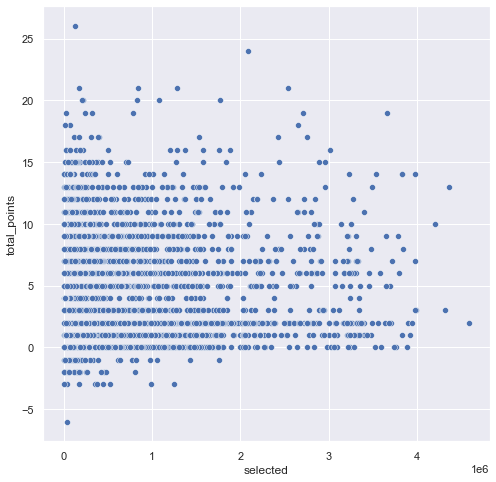

In [53]:
plt.figure(figsize=(8,8))
data = players[players['season'] == 1920][['total_points', 'selected']]
sns.scatterplot(data = data, x = 'selected', y='total_points')

(-500000.0, 500000.0)

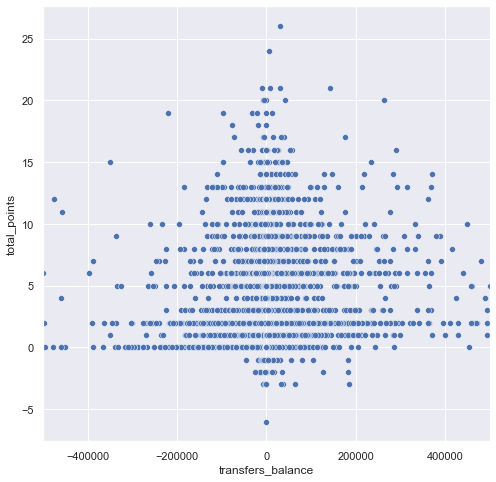

In [54]:
plt.figure(figsize=(8,8))
data = players[players['season'] == 1920][['total_points', 'transfers_balance']]
sns.scatterplot(data = data, x = 'transfers_balance', y='total_points')
plt.xlim(-500000, 500000)

<AxesSubplot:xlabel='selected', ylabel='total_points'>

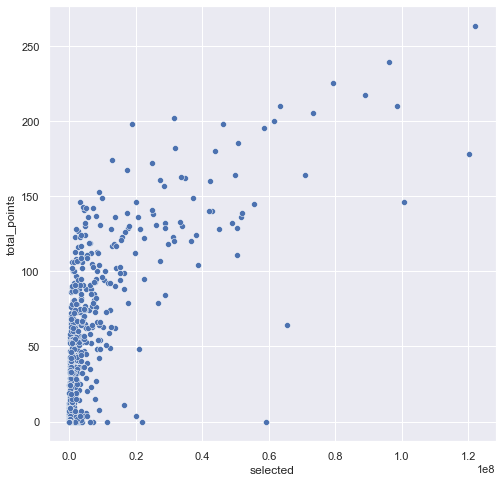

In [55]:
plt.figure(figsize=(8,8))
data = players[players['season'] == 1920].groupby('name')[['total_points', 'selected']].sum().reset_index()
sns.scatterplot(data = data, x = 'selected', y='total_points')

Number of selections starts to matter/make sense at the season level, but we should be careful of putting too much trust in this -- it's possible that a player is highly selected *after* a high-scoring game, such that total selections isn't an effective predictor

In [56]:
data = players.groupby(['name', 'season']).agg({'total_points': ['median', 'sum', 'mean', 'std']}).reset_index()
data.sort_values(('total_points', 'sum'), ascending=False).head(30)

name season total_points                         
                                             median  sum      mean       std
2397              Mohamed Salah   1718          8.0  303  7.973684  5.777341
167              Alexis Sánchez   1617          5.0  264  6.947368  5.321793
1888            Kevin De Bruyne   1920          5.5  263  6.575000  5.500058
2398              Mohamed Salah   1819          6.0  259  6.815789  4.958505
2399              Mohamed Salah   1920          5.0  239  5.975000  5.096442
933                 Eden Hazard   1819          4.0  238  6.263158  5.330606
2714            Raheem Sterling   1819          5.0  234  6.157895  5.800868
2893                 Sadio Mané   1819          3.0  231  6.078947  4.867885
2713            Raheem Sterling   1718          5.5  229  6.026316  4.582498
361               Bamidele Alli   1617          6.0  225  5.921053  4.206697
2894                 Sadio Mané   1920          5.0  225  5.625000  4.481801
931                 Eden Hazard   1617          5.0  224  5.894737  4.397723
1242                 Harry Kane   1617          3.0  224  5.894737  6.475690
2830              Romelu Lukaku   1617          2.0  221  5.815789  5.321325
604           Christian Eriksen   1617          3.0  218  5.736842  4.836149
1243                 Harry Kane   1718          3.0  217  5.710526  5.250008
1480                Jamie Vardy   1920          3.5  217  5.425000  4.971135
224            Andrew Robertson   1819          6.0  213  5.605263  3.759956
2694  Pierre-Emerick Aubameyang   1920          2.5  210  5.250000  4.487875
3203     Trent Alexander-Arnold   1920          5.0  210  5.250000  4.823819
1886            Kevin De Bruyne   1718          3.5  209  5.500000  3.930133
3259            Virgil van Dijk   1819          6.0  208  5.473684  4.157291
2693  Pierre-Emerick Aubameyang   1819          4.5  205  5.394737  4.517470
2715            Raheem Sterling   1920          2.5  205  5.125000  5.644092
284             Anthony Martial   1920          3.0  202  5.050000  4.840799
2983              Sergio Agüero   1819          5.0  201  5.289474  4.996798
2733               Raúl Jiménez   1920          5.0  200  5.000000  3.297240
605           Christian Eriksen   1718          4.0  199  5.236842  3.483042
1885            Kevin De Bruyne   1617          3.0  199  5.236842  4.570376
2773               Riyad Mahrez   1920          2.5  198  4.950000  5.387307

Even the best players have many, many games in which they don't earn many points. Aubemeyang, in 2019-2020, for example, earned 205 points for the season with a median of only 2 points!

<AxesSubplot:xlabel="('total_points', 'mean')", ylabel="('total_points', 'std')">

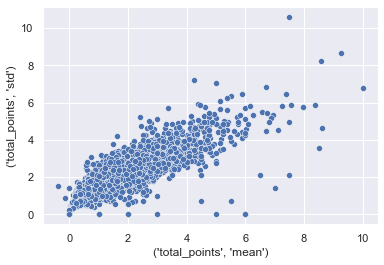

In [57]:
sns.scatterplot(x = data[('total_points', 'mean')], 
                y = data[('total_points', 'std')])

We can see this in the graph above. While I would have thought that the players that earn the most points over the season are the ones who can just produce a solid 5 points, day in and day out, it's actually the players with larger variance in their points that have higher season-long averages

<AxesSubplot:xlabel='date', ylabel='total_points'>

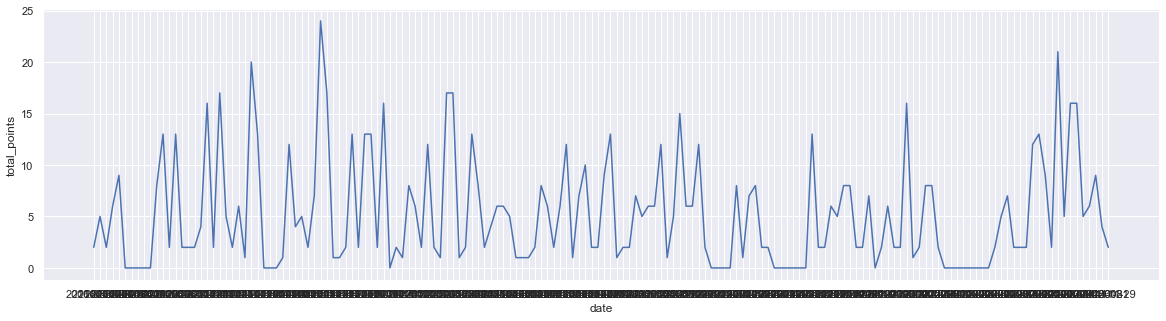

In [58]:
data = players[players.name == 'Harry Kane'][['total_points', 'date']]
plt.figure(figsize=(20,5))
sns.lineplot(x='date', y='total_points', data=data)

In [59]:
data['rolling'] = data.total_points.rolling(4, min_periods=1).sum()

<AxesSubplot:xlabel='date', ylabel='rolling'>

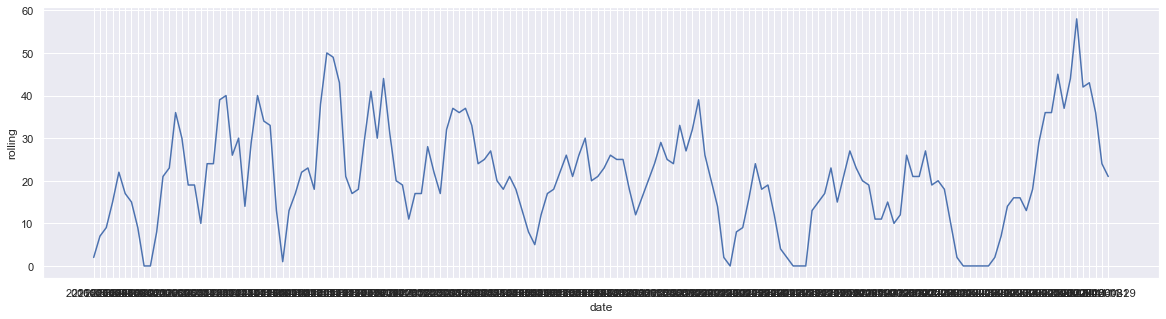

In [60]:
plt.figure(figsize=(20,5))
sns.lineplot(x='date', y='rolling', data=data)

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

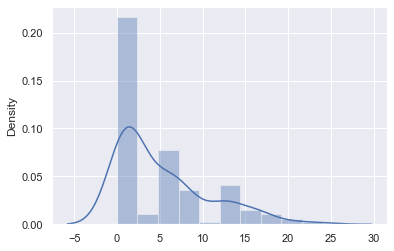

In [61]:
sns.distplot(data['total_points'].values)

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

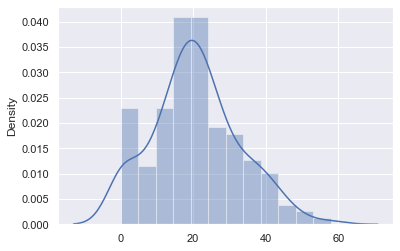

In [62]:
sns.distplot(data['rolling'].values)

In [63]:
#looking at this in 4 game spans significantly smoothes the data for Harry Kane

In [64]:
rolling_points = players.groupby('name')['total_points'].rolling(4, min_periods=2).sum().reset_index()

And continues to look much better & less eratice for players as a whole

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

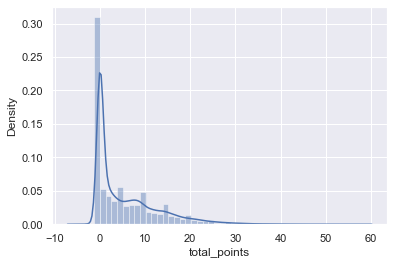

In [65]:
sns.distplot(rolling_points['total_points'])

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

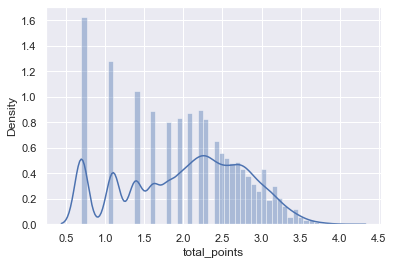

In [66]:
sns.distplot(np.log1p(rolling_points[rolling_points['total_points'] > 0]['total_points']))

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

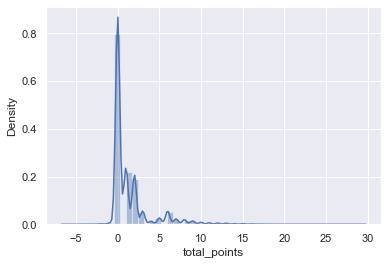

In [67]:
sns.distplot(players['total_points'])

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

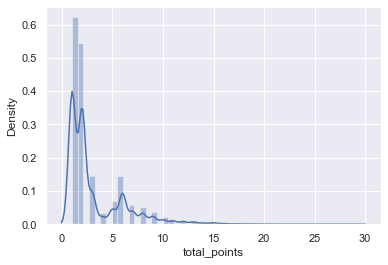

In [68]:
sns.distplot(players[players['total_points'] > 0]['total_points'])

# Null rows addressed, proceed with feature engineering

In [69]:
players['spi_d'] = players['spi'] - players['spi_opp']
players['proj_score_d'] = players['proj_score'] - players['proj_score_opp']

In [70]:
#I'm going to begin by shifting feature rows, so that we don't inadvertantly use data from a 
# game to try to predict points earned in that same game

rolling_cols = ['total_points', 'bps', 'creativity', 'ict_index', 'influence', 
                'threat', 'minutes', 'transfers_balance']
players = players.sort_values(['name', 'date'])
players = players.join(players.groupby('name')[rolling_cols].shift(), rsuffix = '_shift')

In [71]:
# Now I'll calculate rolling performance, using the shifted data
rolling_cols = ['total_points_shift', 'bps_shift', 'creativity_shift', 
                'ict_index_shift', 'influence_shift', 'threat_shift']
players = players.sort_values(['name', 'date'])

rolling_3 = players.groupby('name')[rolling_cols].rolling(window=3, min_periods=1).mean().reset_index()
rolling_5 = players.groupby('name')[rolling_cols].rolling(window=5, min_periods=1).mean().reset_index()
rolling_7 = players.groupby('name')[rolling_cols].rolling(window=7, min_periods=1).mean().reset_index()
rolling_30 = players.groupby('name')[rolling_cols].rolling(window=30, min_periods=1).mean().reset_index()

In [72]:
rolling_3_5 = rolling_3.merge(rolling_5, on='level_1', suffixes=['_3', '_5'])
rolling_7_30 = rolling_7.merge(rolling_30, on='level_1', suffixes=['_7', '_30'])
rolling_performance = rolling_3_5.merge(rolling_7_30, on='level_1')

In [73]:
players = players.merge(rolling_performance, left_index = True, right_on = 'level_1')

In [74]:
#Now calculate rolling values for columns that are more important in the near term, like player minutes and transfer balance

rolling_cols = ['minutes_shift', 'transfers_balance_shift']
players = players.sort_values(['name', 'date'])

rolling_2 = players.groupby('name')[rolling_cols].rolling(window=2, min_periods=1).mean().reset_index()
rolling_3 = players.groupby('name')[rolling_cols].rolling(window=3, min_periods=1).mean().reset_index()
rolling_5 = players.groupby('name')[rolling_cols].rolling(window=5, min_periods=1).mean().reset_index()

In [75]:
rolling_3_5 = rolling_3.merge(rolling_5, on='level_1', suffixes=['_3', '_5'])
rolling_2 = rolling_2.rename(columns={'minutes_shift': 'minutes_shift_2',
                         'transfers_balance_shift': 'transfers_balance_shift_2'})
rolling_value = rolling_2.merge(rolling_3_5, on='level_1')

In [76]:
players = players.merge(rolling_value, left_index = True, right_on = 'level_1')

In [77]:
list(players)

['level_1',
 'name_x',
 'gw',
 'position',
 'minutes',
 'team',
 'opponent_team',
 'was_home',
 'total_points',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'transfers_balance',
 'transfers_in',
 'transfers_out',
 'yellow_cards',
 'kickoff_time',
 'season',
 'value',
 'date',
 'team_opp',
 'spi',
 'spi_opp',
 'proj_score',
 'proj_score_opp',
 'prob_w',
 'prob_l',
 'probtie',
 'importance',
 'importance_opp',
 'spi_d',
 'proj_score_d',
 'total_points_shift',
 'bps_shift',
 'creativity_shift',
 'ict_index_shift',
 'influence_shift',
 'threat_shift',
 'minutes_shift',
 'transfers_balance_shift',
 'name_3_x',
 'level_1_x',
 'total_points_shift_3',
 'bps_shift_3',
 'creativity_shift_3',
 'ict_index_shift_3',
 'influence_shift_3',
 'threat_shift_3',
 'name_5_x',
 'total_points_shift_5',
 'b

In [78]:
players = players.rename(columns={'name_x': 'name'})

In [79]:
players = players.drop(columns=['level_1', 'name_3_x', 'level_1_x', 'name_5_x', 'name_7', 'name_30', 'name_y', 'level_1_y',
                     'name_3_y', 'name_5_y'])

In [80]:
# shifting the data gives us NaN for the first record we have of each player
# for now, we're going to drop NaNs

players = players.dropna()

In [81]:
players.sort_values(['name', 'date'])

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,total_points_shift,bps_shift,creativity_shift,ict_index_shift,influence_shift,threat_shift,minutes_shift,transfers_balance_shift,total_points_shift_3,bps_shift_3,creativity_shift_3,ict_index_shift_3,influence_shift_3,threat_shift_3,total_points_shift_5,bps_shift_5,creativity_shift_5,ict_index_shift_5,influence_shift_5,threat_shift_5,total_points_shift_7,bps_shift_7,creativity_shift_7,ict_index_shift_7,influence_shift_7,threat_shift_7,total_points_shift_30,bps_shift_30,creativity_shift_30,ict_index_shift_30,influence_shift_30,threat_shift_30,minutes_shift_2,transfers_balance_shift_2,minutes_shift_3,transfers_balance_shift_3,minutes_shift_5,transfers_balance_shift_5
1,Aaron Connolly,5,4,6,Brighton and Hove Albion,Burnley,True,1,0,0,1,0,0.3,1,0,2.2,1.0,0,0,0,0,14029,1,1,21.0,10589,13500,2911,0,2019-09-14T14:00:00Z,1920,0.0,2019-09-14,Burnley,64.86,69.10,1.35,1.14,0.4130,0.3114,0.2756,44.2,27.6,-4.24,0.21,1.0,1.0,0.1,0.0,0.2,0.0,24.0,0.0,1.0,1.000000,0.100000,0.000000e+00,0.200000,0.000000,1.0,1.00,1.000000e-01,0.000000,2.000000e-01,0.00,1.0,1.00,1.000000e-01,0.000000e+00,0.200000,0.00,1.000000,1.000000,0.100000,0.000000,0.200000,0.00,24.0,0.0,24.000000,0.000000,24.000000,0.000000
2,Aaron Connolly,6,4,20,Brighton and Hove Albion,Newcastle United,False,1,0,0,1,0,4.8,0,0,2.5,2.0,0,0,0,0,22804,0,0,18.0,8090,11749,3659,0,2019-09-21T16:30:00Z,1920,0.0,2019-09-21,Newcastle United,65.56,68.53,0.94,1.41,0.2498,0.4730,0.2772,43.9,39.4,-2.97,-0.47,1.0,1.0,0.3,2.2,1.0,21.0,6.0,10589.0,1.0,1.000000,0.200000,1.100000e+00,0.600000,10.500000,1.0,1.00,2.000000e-01,1.100000,6.000000e-01,10.50,1.0,1.00,2.000000e-01,1.100000e+00,0.600000,10.50,1.000000,1.000000,0.200000,1.100000,0.600000,10.50,15.0,5294.5,15.000000,5294.500000,15.000000,5294.500000
3,Aaron Connolly,7,4,25,Brighton and Hove Albion,Chelsea,False,1,0,0,2,0,0.6,1,0,0.1,0.2,0,0,0,0,32699,0,2,0.0,8437,13439,5002,0,2019-09-28T14:00:00Z,1920,0.0,2019-09-28,Chelsea,66.70,84.10,0.69,2.14,0.1060,0.7050,0.1889,34.8,60.3,-17.40,-1.45,1.0,1.0,4.8,2.5,2.0,18.0,20.0,8090.0,1.0,1.000000,1.733333,1.566667e+00,1.066667,13.000000,1.0,1.00,1.733333e+00,1.566667,1.066667e+00,13.00,1.0,1.00,1.733333e+00,1.566667e+00,1.066667,13.00,1.000000,1.000000,1.733333,1.566667,1.066667,13.00,13.0,9339.5,16.666667,6226.333333,16.666667,6226.333333
4,Aaron Connolly,8,4,79,Brighton and Hove Albion,Tottenham Hotspur,True,13,0,3,53,1,23.8,0,2,20.1,70.2,0,0,0,0,35026,0,3,107.0,2156,5952,3796,0,2019-10-05T11:30:00Z,1920,0.0,2019-10-05,Tottenham Hotspur,65.79,82.63,1.07,1.74,0.2294,0.5279,0.2426,37.9,61.3,-16.84,-0.67,1.0,2.0,0.6,0.1,0.2,0.0,25.0,8437.0,1.0,1.333333,1.900000,1.600000e+00,1.066667,13.000000,1.0,1.25,1.450000e+00,1.200000,8.500000e-01,9.75,1.0,1.25,1.450000e+00,1.200000e+00,0.850000,9.75,1.000000,1.250000,1.450000,1.200000,0.850000,9.75,22.5,8263.5,17.000000,9038.666667,18.750000,6779.000000
5,Aaron Connolly,9,4,45,Brighton and Hove Albion,Aston Villa,False,1,0,0,3,0,10.6,1,0,3.6,4.4,0,0,0,0,110944,1,2,21.0,70802,81069,10267,0,2019-10-19T14:00:00Z,1920,0.0,2019-10-19,Aston Villa,68.56,65.69,1.12,1.43,0.2921,0.4381,0.2699,34.4,43.5,2.87,-0.31,13.0,53.0,23.8,20.1,70.2,107.0,79.0,2156.0,5.0,18.666667,9.733333,7.566667e+00,24.133333,41.666667,3.4,11.60,5.920000e+00,4.980000,1.472000e+01,29.20,3.4,11.60,5.920000e+00,4.980000e+00,14.720000,29.20,3.400000,11.600000,5.920000,4.980000,14.720000,29.20,52.0,5296.5,41.333333,6227.666667,30.800000,5854.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Forward Looking Values

We've engineered features to aggregate performance over the past X games. We want our target value to show how the player performed over the *next* X games -- a forward looking rolling window. There are also some features that we know before the game, and will make sense to have has forward rolling features:

'spi',
'spi_opp',
'proj_score',
'proj_score_opp',
'prob_w',
'prob_l',
'probtie',
'importance',
'importance_opp',
'spi_d',
'proj_score_d'

In [82]:
forward_cols = ['total_points',
                'spi',
                'spi_opp',
                'proj_score',
                'proj_score_opp',
                'prob_w',
                'prob_l',
                'probtie',
                'spi_d',
                'proj_score_d']

In [83]:
forward = pd.DataFrame()
for player in players.name.unique():
    section = players[players['name'] == player][forward_cols][::-1].rolling(4).sum()[::-1]
    forward = forward.append(section)

In [84]:
forward

,total_points,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,spi_d,proj_score_d
1,16.0,262.91,304.36,4.05,6.43,0.9982,2.0173,0.9843,-41.45,-2.38
2,16.0,266.61,300.95,3.82,6.72,0.8773,2.1440,0.9786,-34.34,-2.90
3,23.0,268.62,310.22,4.09,6.56,0.9783,2.0404,0.9812,-41.60,-2.47
4,24.0,269.92,285.77,5.07,5.46,1.3892,1.5687,1.0422,-15.85,-0.39
5,12.0,273.52,284.43,4.76,5.43,1.3217,1.6373,1.0412,-10.91,-0.67
...,...,...,...,...,...,...,...,...,...,...
96084,0.0,289.77,293.46,5.87,5.48,1.5973,1.4186,0.9841,-3.69,0.39
96085,0.0,288.71,302.18,5.44,6.07,1.3735,1.6382,0.9883,-13.47,-0.63
96086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
players = players.join(forward, rsuffix = '_forward')

# Additional Features: normalize data & replace NaN

In [86]:
players.position = players.position.replace({'GK': 1,
                                            'DEF': 2,
                                            'MID': 3,
                                            'FWD': 4})

In [87]:
players.loc[players['total_points'] < 0, 'total_points'] = 0
players.loc[players['total_points_forward'] < 0, 'total_points_forward'] = 0

In [88]:
players.describe()

,gw,position,minutes,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,season,value,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,total_points_shift,bps_shift,creativity_shift,ict_index_shift,influence_shift,threat_shift,minutes_shift,transfers_balance_shift,total_points_shift_3,bps_shift_3,creativity_shift_3,ict_index_shift_3,influence_shift_3,threat_shift_3,total_points_shift_5,bps_shift_5,creativity_shift_5,ict_index_shift_5,influence_shift_5,threat_shift_5,total_points_shift_7,bps_shift_7,creativity_shift_7,ict_index_shift_7,influence_shift_7,threat_shift_7,total_points_shift_30,bps_shift_30,creativity_shift_30,ict_index_shift_30,influence_shift_30,threat_shift_30,minutes_shift_2,transfers_balance_shift_2,minutes_shift_3,transfers_balance_shift_3,minutes_shift_5,transfers_balance_shift_5,total_points_forward,spi_forward,spi_opp_forward,proj_score_forward,proj_score_opp_forward,prob_w_forward,prob_l_forward,probtie_forward,spi_d_forward,proj_score_d_forward
count,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,9.466300e+04,94663.000000,94663.000000,94663.000000,9.466300e+04,9.466300e+04,9.466300e+04,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,9.466300e+04,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,9.466300e+04,94663.000000,9.466300e+04,94663.000000,94663.000000,94663.000000,9.466300e+04,9.466300e+04,9.466300e+04,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,94663.000000,9.466300e+04,94663.000000,9.466300e+04,94663.000000,94663.000000,90445.000000,90445.000000,90445.000000,90445.000000,90445.000000,90445.000000,90445.000000,90445.00000,90445.000000,90445.000000
mean,19.618309,2.592977,33.309709,1.392445,0.041072,0.108120,6.264929,0.108015,4.988256,0.512967,0.045202,1.800968,7.499264,0.001025,0.000782,0.001923,0.098180,1.482654e+05,1.213864,1.548884,5.534855,4.320770e+02,9.730953e+03,9.298261e+03,0.055819,1780.488702,0.659899,69.149838,69.372646,1.399291,1.413969,0.379567,0.384875,0.235560,34.403709,34.577857,-0.222808,-0.014678,1.389582,6.283701,5.000719,1.805979,7.522251,5.549972,33.409780,4.396139e+02,1.394336,6.306433,5.014567,1.811722,7.550661,5.565673,1.399412,6.331124,5.035964e+00,1.819258,7.581416e+00,5.589271,1.404958,6.357401,5.058917e+00,1.826957e+00,7.612127e+00,5.612983,1.451061,6.577898,5.277092,1.897750,7.871966,5.845709,33.465013,4.439211e+02,33.522571,4.521824e+02,33.643501,482.727874,5.614639,276.906901,277.291816,5.613656,5.647804,1.523437,1.535142,0.94143,-0.384916,-0.034148
std,11.158846,0.859370,40.841607,2.525609,0.215994,0.490905,9.960425,0.310401,11.028043,0.980854,0.233509,3.116527,13.125820,0.031995,0.028694,0.043806,0.641549,3.446238e+05,1.207696,1.306714,13.818666,4.367475e+04,3.751733e+04,3.251744e+04,0.229573,123.389134,5.980829,12.023862,12.121017,0.554523,0.560795,0.205878,0.207006,0.052039,26.005731,26.083356,16.524907,1.054501,2.531510,9.962797,11.029714,3.117060,13.130868,13.821135,40.851112,4.341576e+04,1.913764,7.973643,8.790027,2.535529,10.235762,10.827915,1.745348,7.411665,8.218225e+00,2.377240,9.438079e+00,10.062365,1.659632,7.115001,7.933669e+00,2.294238e+00,9.024910e+00,9.683396,1.432059,6.254271,7.279116,2.078441,7.887795,8.822664,38.025988,3.506284e+04,36.685978,3.054621e+04,35.108075,25160.759630,7.220580,47.916480,25.722133,1

The total points data is incredibly skewed left, because 50% of rows represent players who played 0 minutes

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

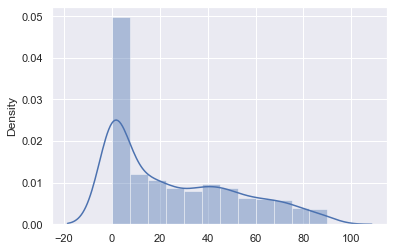

In [89]:
# Distribution of mean minutes played, aggreagated by player
# lots of players where their *mean* over all games is less than 25 minutes
sns.distplot(players.groupby('name')['minutes'].mean().values)

# How do we handle players with low minutes?
To implement: Try dropping players who played 0 minutes in the previous game (or who averaged less than 45 minutes in the past 3?)
Over two-thirds our players have averaged less than 50 minutes -- lets drop those players

In [90]:
players.groupby('total_points')[['minutes_shift', 'minutes_shift_2', 'minutes_shift_3']].median()

,minutes_shift,minutes_shift_2,minutes_shift_3
total_points,,,
0,0.0,0.00,0.000000
1,60.0,45.00,48.666667
2,90.0,86.00,80.666667
3,90.0,84.50,80.666667
4,77.0,56.50,60.000000
5,90.0,84.50,79.000000
6,90.0,90.00,88.333333
7,90.0,90.00,83.333333
8,90.0,87.00,81.666667


/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

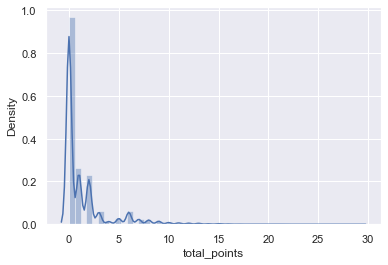

In [91]:
sns.distplot(players.total_points)

In [92]:
len(players)

94663

In [93]:
players = players[players['minutes_shift_2'] > 45]

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='minutes_shift_2', ylabel='Density'>

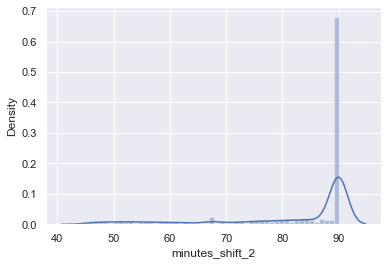

In [94]:
sns.distplot(players.minutes_shift_2)

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points', ylabel='Density'>

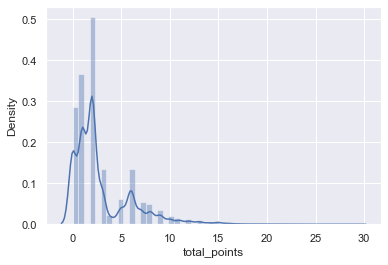

In [95]:
sns.distplot(players.total_points)

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='total_points_forward', ylabel='Density'>

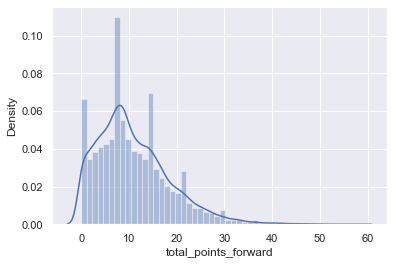

In [96]:
sns.distplot(players.total_points_forward)

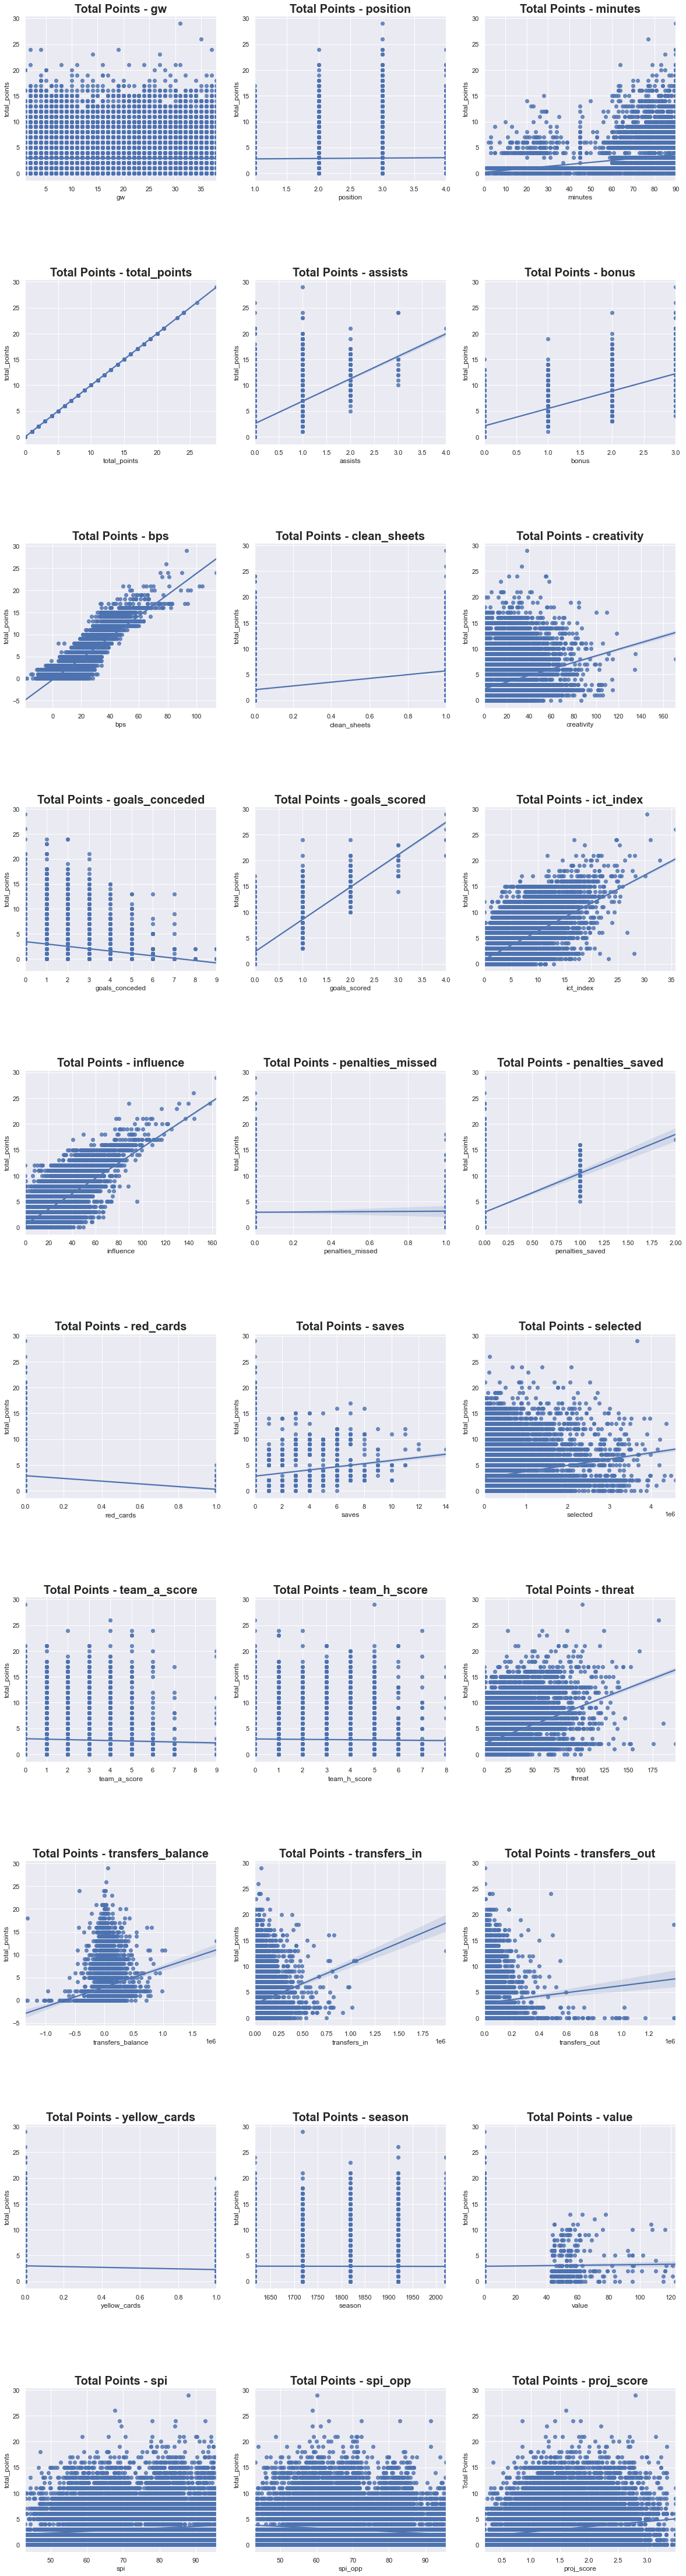

In [97]:
#Visualising numerical predictor variables with Target Variables

players_num = players.select_dtypes(include=['int64','float64'])
fig,axs= plt.subplots(10,3,figsize=(20,80))
#adjust horizontal space between plots 
fig.subplots_adjust(hspace=0.6)
for i,ax in zip(players_num.columns,axs.flatten()):
    sns.regplot(x = i, y = 'total_points',data = players_num, ax = ax, color = 'b')
    plt.xlabel(i,fontsize=12)
    plt.ylabel('Total Points',fontsize=12)
    #ax.set_yticks(np.arange(0,900001,100000))
    ax.set_title('Total Points'+' - '+str(i),fontweight='bold',size=20)

Most of the 538 features have no correlation with total points! Consider dropping spi, spi_opp, proj_score, proj_score_opp

In [98]:
print("Skewness: %f" % players['total_points_forward'].skew())
print("Kurtosis: %f" % players['total_points_forward'].kurt())

Skewness: 0.988958
Kurtosis: 1.337656


In [99]:
#the forward looking calculations create NA's
players.isna().sum()

name                           0
gw                             0
position                       0
minutes                        0
team                           0
opponent_team                  0
was_home                       0
total_points                   0
assists                        0
bonus                          0
bps                            0
clean_sheets                   0
creativity                     0
goals_conceded                 0
goals_scored                   0
ict_index                      0
influence                      0
penalties_missed               0
penalties_saved                0
red_cards                      0
saves                          0
selected                       0
team_a_score                   0
team_h_score                   0
threat                         0
transfers_balance              0
transfers_in                   0
transfers_out                  0
yellow_cards                   0
kickoff_time                   0
season    

In [100]:
players = players.dropna()

In [101]:
#instead of using spi to evaluate matches, we can use team-level fpl points data
team_level = players.groupby(['team', 'date', 'position'])['total_points'].sum().reset_index()

In [102]:
team_level = team_level.pivot_table(index=['team', 'date'], columns = 'position')['total_points'].reset_index()

In [103]:
team_level.head()

position,team,date,1,2,3,4
0,Arsenal,2016-08-20,6.0,23.0,8.0,NaN
1,Arsenal,2016-08-27,4.0,6.0,34.0,NaN
2,Arsenal,2016-09-10,1.0,13.0,14.0,NaN
3,Arsenal,2016-09-17,1.0,8.0,27.0,1.0
4,Arsenal,2016-09-24,6.0,29.0,39.0,NaN


In [104]:
team_level = team_level.fillna(0)

In [105]:
team_level = team_level.rename(columns={1: 'gk_points', 2: 'def_points', 3: 'mid_points', 4: 'fwd_points'})

In [106]:
rolling_team_3 = (team_level.groupby('team').rolling(window=3, min_periods=1, on='date').
    mean().reset_index().drop('level_1', axis=1))

In [107]:
rolling_team_5 = (team_level.groupby('team').rolling(window=5, min_periods=1, on='date').
    mean().reset_index().drop('level_1', axis=1))

In [108]:
rolling_team_7 = (team_level.groupby('team').rolling(window=7, min_periods=1, on='date').
    mean().reset_index().drop('level_1', axis=1))

In [109]:
rolling_team_12 = (team_level.groupby('team').rolling(window=12, min_periods=1, on='date').
    mean().reset_index().drop('level_1', axis=1))

In [110]:
rolling_team_35 = rolling_team_3.merge(rolling_team_5, on=['team', 'date'], suffixes = ['_3', '_5'])
rolling_team_712 = rolling_team_7.merge(rolling_team_12, on=['team', 'date'], suffixes = ['_7', '_12'])

In [111]:
rolling_team = rolling_team_35.merge(rolling_team_712, on=['team', 'date'])

In [112]:
players = players.merge(rolling_team, on = ['team', 'date'])

In [113]:
#add in opponent past performance
players = players.merge(rolling_team, left_on = ['opponent_team', 'date'], right_on = ['team', 'date'],
             suffixes = ['', '_opp'])

In [114]:
for col in ['gk_points', 'def_points', 'mid_points', 'fwd_points']:
    for window in ['_3', '_5', '_7', '_12']:
        players[col + window + '_adv'] = players[col + window] - players[col + window + '_opp']

In [115]:
players

,name,gw,position,minutes,team,opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,value,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,spi_d,proj_score_d,total_points_shift,bps_shift,creativity_shift,ict_index_shift,influence_shift,threat_shift,minutes_shift,transfers_balance_shift,total_points_shift_3,bps_shift_3,creativity_shift_3,ict_index_shift_3,influence_shift_3,threat_shift_3,total_points_shift_5,bps_shift_5,creativity_shift_5,ict_index_shift_5,influence_shift_5,threat_shift_5,total_points_shift_7,bps_shift_7,creativity_shift_7,ict_index_shift_7,influence_shift_7,threat_shift_7,total_points_shift_30,bps_shift_30,creativity_shift_30,ict_index_shift_30,influence_shift_30,threat_shift_30,minutes_shift_2,transfers_balance_shift_2,minutes_shift_3,transfers_balance_shift_3,minutes_shift_5,transfers_balance_shift_5,total_points_forward,spi_forward,spi_opp_forward,proj_score_forward,proj_score_opp_forward,prob_w_forward,prob_l_forward,probtie_forward,spi_d_forward,proj_score_d_forward,gk_points_3,def_points_3,mid_points_3,fwd_points_3,gk_points_5,def_points_5,mid_points_5,fwd_points_5,gk_points_7,def_points_7,mid_points_7,fwd_points_7,gk_points_12,def_points_12,mid_points_12,fwd_points_12,team_opp,gk_points_3_opp,def_points_3_opp,mid_points_3_opp,fwd_points_3_opp,gk_points_5_opp,def_points_5_opp,mid_points_5_opp,fwd_points_5_opp,gk_points_7_opp,def_points_7_opp,mid_points_7_opp,fwd_points_7_opp,gk_points_12_opp,def_points_12_opp,mid_points_12_opp,fwd_points_12_opp,gk_points_3_adv,gk_points_5_adv,gk_points_7_adv,gk_points_12_adv,def_points_3_adv,def_points_5_adv,def_points_7_adv,def_points_12_adv,mid_points_3_adv,mid_points_5_adv,mid_points_7_adv,mid_points_12_adv,fwd_points_3_adv,fwd_points_5_adv,fwd_points_7_adv,fwd_points_12_adv
0,Aaron Connolly,9,4,45,Brighton and Hove Albion,Aston Villa,False,1,0,0,3,0,10.6,1,0,3.6,4.4,0,0,0,0,110944,1,2,21.0,70802,81069,10267,0,2019-10-19T14:00:00Z,1920,0.0,2019-10-19,Aston Villa,68.56,65.69,1.12,1.43,0.2921,0.4381,0.2699,34.4,43.5,2.87,-0.31,13.0,53.0,23.8,20.1,70.2,107.0,79.0,2156.0,5.000000,18.666667,9.733333,7.566667,24.133333,41.666667,3.4,11.6,5.92,4.98,14.72,29.2,3.400000,11.600000,5.920000,4.980000,14.720000,29.200000,3.400000,11.600000,5.920000,4.980000,14.720000,29.200000,52.0,5296.5,41.333333,6227.666667,30.8,5854.4,12.0,273.52,284.43,4.76,5.43,1.3217,1.6373,1.0412,-10.91,-0.67,4.666667,13.333333,8.000000,3.666667,5.2,12.8,9.2,4.2,3.857143,9.571429,8.714286,3.428571,3.750000,8.583333,7.916667,4.083333,Aston Villa,2.333333,11.333333,23.000000,6.000000,3.0,12.2,18.8,5.4,3.428571,12.714286,17.142857,5.428571,3.000000,10.444444,14.666667,4.444444,2.333333,2.2,0.428571,0.750000,2.000000,0.6,-3.142857,-1.861111,-15.000000,-9.6,-8.428571,-6.750000,-2.333333,-1.2,-2.000000,-0.361111
1,Aaron Mooy,9,3,34,Brighton and Hove Albion,Aston Villa,False,0,0,0,-7,0,1.5,2,0,0.0,0.0,0,0,1,0,12741,1,2,0.0,1264,2039,775,0,2019-10-19T14:00:00Z,1920,0.0,2019-10-19,Aston Villa,68.56,65.69,1.12,1.43,0.2921,0.4381,0.2699,34.4,43.5,2.87,-0.31,3.0,15.0,14.9,3.5,19.0,1.0,90.0,-370.0,2.666667,12.333333,10.233333,3.000000,16.466667,3.333333,1.8,8.2,6.32,1.84,10.16,2.0,1.428571,6.285714,4.585714,1.328571,7.285714,1.428571,1.400000,7.066667,9.990000,2.370000,8.606667,5.100000,77.0,-454.0,74.333333,-620.000000,46.6,-1270.8,0.0,273.52,284.43,4.76,5.43,1.3217,1.6373,1.0412,-10.91,-0.67,4.666667,13.333333,8.000000,3.666667,5.2,12.8,9.2,4.2,3.857143,9.571429,8.714286,3.428571,3.750000,8.583333,7.916667,4.083333,Aston Villa,2.333333,11.333333,23.000000,6.000000,3.0,12.2,18.8,5.4,3.428571,12.714286,17.142857,5.428571,3.000000,10.444444,14.666667,4.444444,2.333333,2.2,0.428571,0.750000,2.000000,0.6,-3.142857,-1.861111,-15.000000

In [116]:
feature_cols = ['position',
'total_points_shift',
 'bps_shift',
 'creativity_shift',
 'ict_index_shift',
 'influence_shift',
 'threat_shift',
 'minutes_shift',
 'transfers_balance_shift',
 'total_points_shift_3',
 'bps_shift_3',
 'creativity_shift_3',
 'ict_index_shift_3',
 'influence_shift_3',
 'threat_shift_3',
 'total_points_shift_5',
 'bps_shift_5',
 'creativity_shift_5',
 'ict_index_shift_5',
 'influence_shift_5',
 'threat_shift_5',
 'total_points_shift_7',
 'bps_shift_7',
 'creativity_shift_7',
 'ict_index_shift_7',
 'influence_shift_7',
 'threat_shift_7',
 'total_points_shift_30',
 'bps_shift_30',
 'creativity_shift_30',
 'ict_index_shift_30',
 'influence_shift_30',
 'threat_shift_30',
 'minutes_shift_2',
 'transfers_balance_shift_2',
 'minutes_shift_3',
 'transfers_balance_shift_3',
 'minutes_shift_5',
 'transfers_balance_shift_5',
 'gk_points_3',
 'def_points_3',
 'mid_points_3',
 'fwd_points_3',
 'gk_points_5',
 'def_points_5',
 'mid_points_5',
 'fwd_points_5',
 'gk_points_7',
 'def_points_7',
 'mid_points_7',
 'fwd_points_7',
 'gk_points_12',
 'def_points_12',
 'mid_points_12',
 'fwd_points_12',
 'gk_points_3_opp',
 'def_points_3_opp',
 'mid_points_3_opp',
 'fwd_points_3_opp',
 'gk_points_5_opp',
 'def_points_5_opp',
 'mid_points_5_opp',
 'fwd_points_5_opp',
 'gk_points_7_opp',
 'def_points_7_opp',
 'mid_points_7_opp',
 'fwd_points_7_opp',
 'gk_points_12_opp',
 'def_points_12_opp',
 'mid_points_12_opp',
 'fwd_points_12_opp',
 'gk_points_3_adv',
 'gk_points_5_adv',
 'gk_points_7_adv',
 'gk_points_12_adv',
 'def_points_3_adv',
 'def_points_5_adv',
 'def_points_7_adv',
 'def_points_12_adv',
 'mid_points_3_adv',
 'mid_points_5_adv',
 'mid_points_7_adv',
 'mid_points_12_adv',
 'fwd_points_3_adv',
 'fwd_points_5_adv',
 'fwd_points_7_adv',
 'fwd_points_12_adv']

<AxesSubplot:>

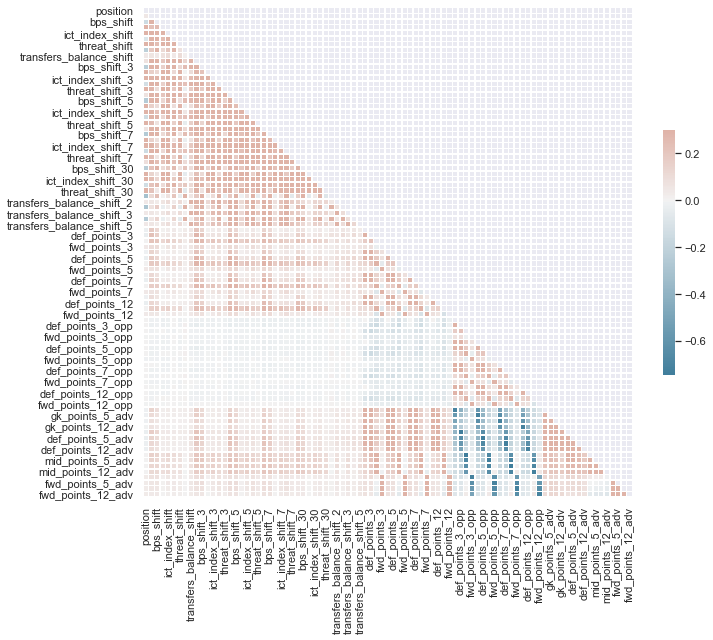

In [117]:
#taken from seaborn gallery

# Compute the correlation matrix
corr = players[feature_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Begin ML Work

In [118]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import SGDClassifier

# Preprocessing


## compare classifiers

In [119]:
#make this into a function so I can easily repeat for new data
def process(players):
    features = players[feature_cols]
    labels = players['total_points']
    
    # Encode Position Columns
    features = features.reset_index(drop=True)
    cat_cols = ['position']
    ohe = OneHotEncoder(sparse=False)
    encoded_columns = ohe.fit_transform(features[cat_cols])
    ohe_positions = pd.DataFrame(encoded_columns)
    features = pd.concat([features, ohe_positions], axis=1)
    features = features.drop(columns='position')
    
    #scale data
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)
    y = scaler.fit_transform(labels.values.reshape(-1,1))
    return X, y, scaler, features, labels

In [120]:
X, y, scaler, features, labels = process(players)

In [121]:
'''
for axis in np.arange(0,X.shape[1], 1):
    sns.distplot(X[axis])
    # sns.distplot(X[axis])
    plt.show()
'''

'\nfor axis in np.arange(0,X.shape[1], 1):\n    sns.distplot(X[axis])\n    # sns.distplot(X[axis])\n    plt.show()\n'

/Users/andrewpeters/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

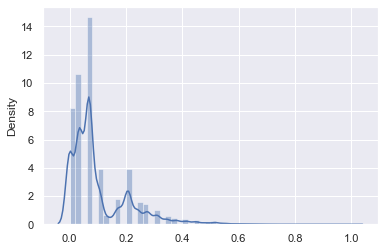

In [122]:
sns.distplot(y)

Text(0.5, 1.0, 'Probplot y')

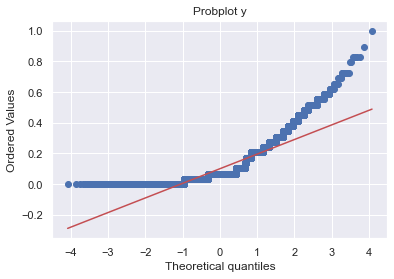

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111)
res = stats.probplot(y.ravel(), plot=ax)
ax.set_title("Probplot y")

In [124]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('DTR', DecisionTreeRegressor(max_depth = 50)))
#models.append(('DTC', DecisionTreeClassifier()))
#models.append(('Lasso', LassoCV()))
#models.append(('Elastic Net', ElasticNetCV()))
#models.append(('SGD', SGDRegressor()))
#models.append(('SVR', SVR(kernel='linear')))
#models.append(('SVR_rbf', SVR(kernel='rbf')))
#models.append(('Random Forest', RandomForestRegressor()))
# evaluate each model in turn

DTR: 2.677772 (0.174938)


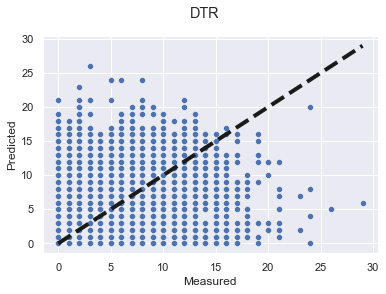

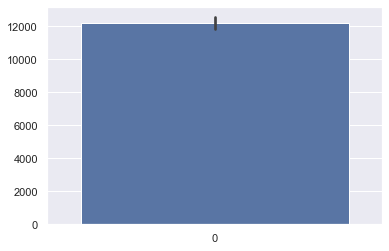

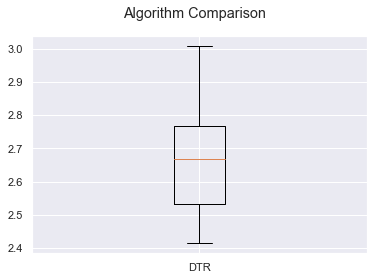

In [163]:
import warnings
warnings.filterwarnings('ignore') 

#commenting out because i've already selected my model

# evaluate each model in turn
features = features
labels = labels
results = []
names = []
scoring = 'neg_mean_absolute_error'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = -model_selection.cross_val_score(model, features, labels, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    predicted = cross_val_predict(model, features, labels, cv=kfold)
    #make scatterplot
    fig, ax = plt.subplots()
    sns.scatterplot(x=labels.ravel(), y=predicted.ravel())
    ax.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'k--', lw=4)
    fig.suptitle(name)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    plt.show()
    dif = predicted.ravel() - labels.ravel()
    fig, ax = plt.subplots()
    sns.barplot(data = [len(dif[dif > 0]), len(dif[dif < 0])])
    plt.show()
    # make heatmap
    # data = np.vstack((pd.cut(labels, bins=10, labels=np.arange(0,10,1)), pd.cut(predicted, bins=10, labels=np.arange(0,10,1)))).T
    # data = pd.DataFrame(data)
    # data['val'] = 'a'
    # data = data.groupby([0,1])['val'].count().reset_index()
    # data = data.pivot(index=0, columns=1, values='val').fillna(0)
    # sns.heatmap(data, vmin=0, vmax=5000)
    # plt.show()
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Kfolds DTR

## settle on Decision Tree Regressor

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=0,
                                                    shuffle=True)

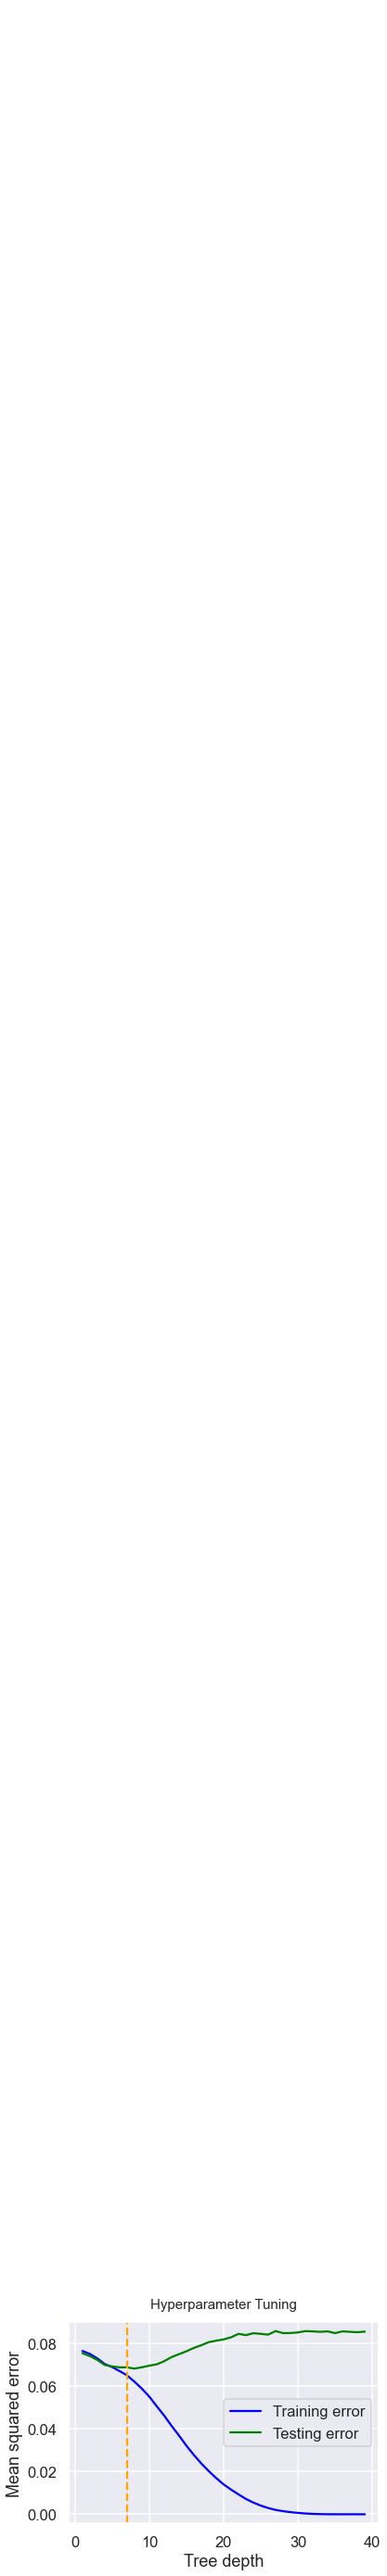

In [144]:
training_error = []
testing_error = []

max_depths = range(1, 40)

for depth in max_depths:
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    training_error.append(mean_absolute_error(model.predict(X_train), y_train))
    testing_error.append(mean_absolute_error(model.predict(X_test), y_test))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')
plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning', pad=15, size=15)
plt.legend()

In [145]:
#clf = RandomForestRegressor()
clf = DecisionTreeRegressor(max_depth = 10)

In [146]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)

scores = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scores.append(
        mean_absolute_error(clf.fit(X_train, y_train).predict(X_test), y_test)
    )
    
np.mean(scores)

0.07357601987987211

In [147]:
scores

[0.06888495626606712,
 0.07512180651625909,
 0.07555202122905463,
 0.07474529550810759]

In [148]:
features.columns

Index([       'total_points_shift',                 'bps_shift',          'creativity_shift',           'ict_index_shift',
                 'influence_shift',              'threat_shift',             'minutes_shift',   'transfers_balance_shift',
            'total_points_shift_3',               'bps_shift_3',        'creativity_shift_3',         'ict_index_shift_3',
               'influence_shift_3',            'threat_shift_3',      'total_points_shift_5',               'bps_shift_5',
              'creativity_shift_5',         'ict_index_shift_5',         'influence_shift_5',            'threat_shift_5',
            'total_points_shift_7',               'bps_shift_7',        'creativity_shift_7',         'ict_index_shift_7',
               'influence_shift_7',            'threat_shift_7',     'total_points_shift_30',              'bps_shift_30',
             'creativity_shift_30',        'ict_index_shift_30',        'influence_shift_30',           'threat_shift_30',
                

In [181]:
# save good classifiers for later :-)
#pickle.dump(clf, open('dtr-23-10-20', 'wb'))

<ipython-input-150-b63d9c3d7250>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


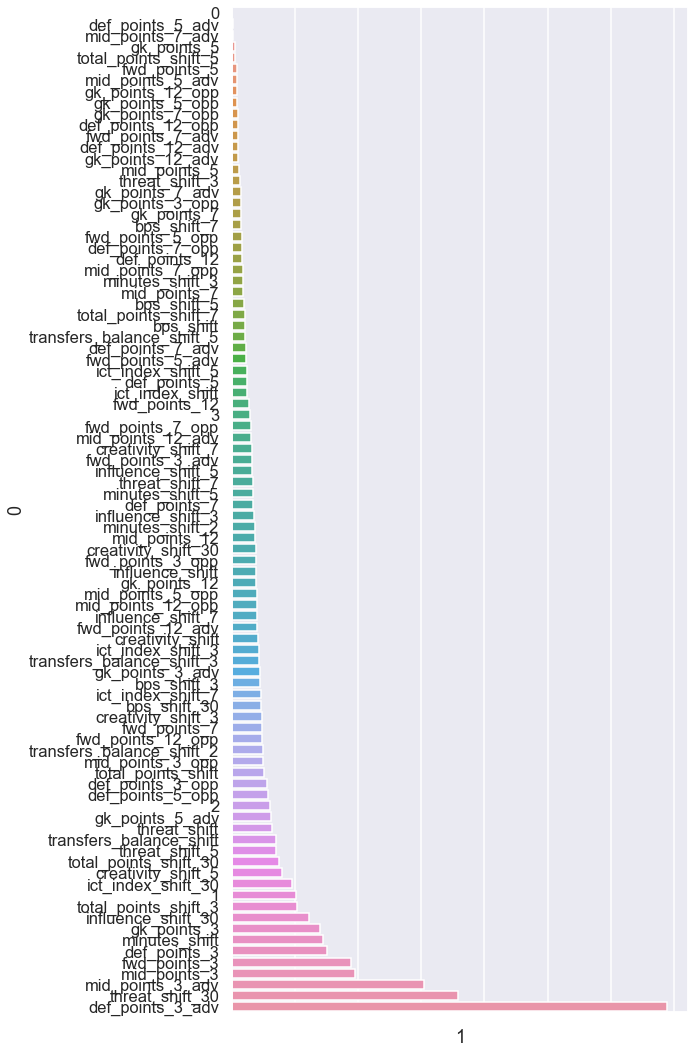

In [150]:
## Look at feature importance in CLF
data = pd.DataFrame(zip(list(features), clf.feature_importances_))
data = data.sort_values(1)
plt.figure(figsize=(10,15))
ax = sns.barplot(x=1, y=0, data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

In [151]:
players['clf_pred'] = scaler.inverse_transform(clf.predict(X).reshape(-1,1))
players['total_points'] = players.total_points.astype('float')

In [152]:
abs(players['clf_pred'] - players['total_points']).mean()

1.758322177962103

In [153]:
players['mse'] = np.square(players.clf_pred - players.total_points)

In [154]:
players.mse.mean()

6.844108993344168

In [155]:
players.groupby('name').agg({'total_points': 'sum',
                            'clf_pred': 'sum'}).reset_index()

,name,total_points,clf_pred
0,Aaron Connolly,33.0,36.656322
1,Aaron Cresswell,247.0,216.813516
2,Aaron Lennon,90.0,94.608967
3,Aaron Mooy,221.0,209.381129
4,Aaron Ramsdale,131.0,102.526971
...,...,...,...
917,Álvaro Arbeloa,0.0,0.907104
918,Álvaro Morata,113.0,131.799528
919,Álvaro Negredo,97.0,92.245148
920,Çaglar Söyüncü,107.0,122.338062


12.103187150635728

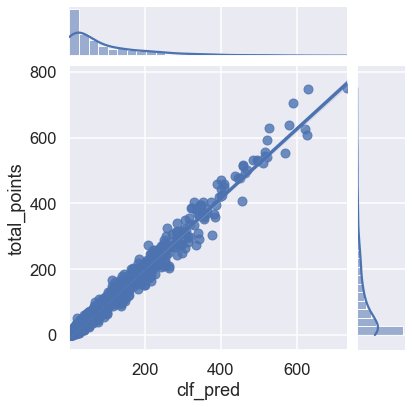

In [156]:
data = players.groupby('name').agg({'total_points': 'sum',
                            'clf_pred': 'sum'}).reset_index()
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=data, x='clf_pred', y='total_points', kind='reg')
mean_absolute_error(data.clf_pred, data.total_points)

24.905792084676108

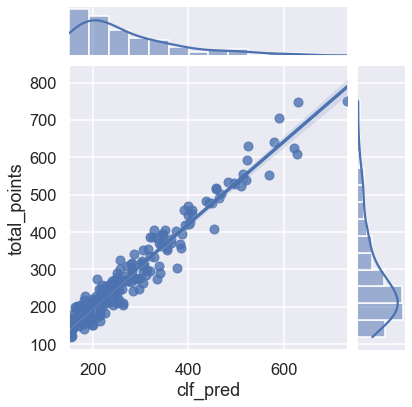

In [157]:
# how does it perform on higher-quality players? pretty well!

data = data[data['clf_pred'] > 150]
sns.set_style('darkgrid')
sns.set('talk')
sns.jointplot(data=data, x='clf_pred', y='total_points', kind='reg')
mean_absolute_error(data.clf_pred, data.total_points)

In [158]:
players.loc[(players['season'] == 2021) & (players['gw'] == 7), ['name', 'total_points', 'clf_pred']].sort_values(
    'clf_pred', ascending=False)

,name,total_points,clf_pred
28835,Max Kilman,6.0,11.000000
13622,Callum Wilson,12.0,10.384615
31361,Harry Kane,6.0,10.384615
6219,Tariq Lamptey,9.0,9.000000
30785,Jack Grealish,15.0,8.000000
11915,Bernd Leno,7.0,7.888889
5283,Dominic Calvert-Lewin,8.0,7.500000
16365,Michy Batshuayi,2.0,7.272727
11005,James Ward-Prowse,17.0,5.466667
15288,Sadio Mané,2.0,4.921630


# Make Predictions for Unplayed Games

In [195]:
last_gw = players.groupby(['season', 'gw'])['total_points'].count().reset_index()['gw'].tail(1).values

In [196]:
last_gw = int(last_gw)

In [203]:
last_results = players[(players.gw == last_gw) & (players.season == 2021)]

In [204]:
#The teachnique will be to merge the last_results with the next 5 games for each player

In [205]:
# add today's date -- only want to look at games in the SPI df after this date
today = '2020-11-3'

In [206]:
spi_2020 = spi[(spi['date'] > today) & (spi['date'] < '2021-06-01')]

In [207]:
drop_cols = ['date',
            'team_opp',
            'spi',
            'spi_opp',
            'proj_score',
            'proj_score_opp',
            'prob_w',
            'prob_l',
            'probtie',
            'importance',
            'importance_opp',
            'opponent_team',
            'was_home',
            'kickoff_time',
            'gw',
            'value']

In [208]:
last_results = last_results.drop(columns=drop_cols)

In [209]:
future = pd.DataFrame()
for player in last_results.name.unique():
    section = last_results[last_results['name'] == player]
    section = section.merge(spi_2020)
    section['gw'] = np.arange(len(section)) + last_gw
    future = future.append(section)

In [210]:
future = future[future['gw'] <= last_gw + 5]

In [211]:
future.isnull().sum()

name                            0
position                        0
minutes                         0
team                            0
total_points                    0
assists                         0
bonus                           0
bps                             0
clean_sheets                    0
creativity                      0
goals_conceded                  0
goals_scored                    0
ict_index                       0
influence                       0
penalties_missed                0
penalties_saved                 0
red_cards                       0
saves                           0
selected                        0
team_a_score                    0
team_h_score                    0
threat                          0
transfers_balance               0
transfers_in                    0
transfers_out                   0
yellow_cards                    0
season                          0
spi_d                           0
proj_score_d                    0
total_points_s

In [335]:
player = 'Matt Doherty'

In [375]:
section['team'] = section.team.astype('str')

In [376]:
section = last_results[last_results['name'] == player]
section = section.merge(spi_2020, left_on='team', right_on='team')

In [366]:
spi_2020['team'] = spi_2020.team.astype('str')

In [367]:
spi_2020[spi_2020['date'] == '2020-10-26']['team']

35850    Brighton and Hove Albion
35859                     Burnley
35850        West Bromwich Albion
35859           Tottenham Hotspur
Name: team, dtype: object

In [377]:
section.date.unique()

array(['2020-11-01', '2020-11-21', '2020-12-05', '2020-12-19',
       '2020-12-28', '2021-01-02', '2021-01-27', '2021-02-03',
       '2021-02-06', '2021-02-27', '2021-03-06', '2021-03-20',
       '2021-04-10', '2021-05-01', '2021-05-12', '2021-05-15',
       '2020-10-26', '2020-11-07', '2020-11-29', '2020-12-12',
       '2020-12-16', '2020-12-26', '2021-01-12', '2021-01-16',
       '2021-01-30', '2021-02-13', '2021-02-20', '2021-03-13',
       '2021-04-03', '2021-04-17', '2021-04-24', '2021-05-08',
       '2021-05-23'], dtype=object)

In [380]:
#not everyone's affected -- Arsenal's dates look right
players[players.team == 'Arsenal'].sort_values('date').date.unique()

array(['2016-08-20', '2016-08-27', '2016-09-10', '2016-09-17',
       '2016-09-24', '2016-10-02', '2016-10-15', '2016-10-22',
       '2016-10-29', '2016-11-06', '2016-11-19', '2016-11-27',
       '2016-12-03', '2016-12-10', '2016-12-13', '2016-12-18',
       '2016-12-26', '2017-01-01', '2017-01-03', '2017-01-14',
       '2017-01-22', '2017-01-31', '2017-02-04', '2017-02-11',
       '2017-03-04', '2017-03-18', '2017-04-02', '2017-04-05',
       '2017-04-10', '2017-04-17', '2017-04-26', '2017-04-30',
       '2017-05-07', '2017-05-10', '2017-05-13', '2017-05-16',
       '2017-05-21', '2017-08-11', '2017-08-19', '2017-08-27',
       '2017-09-09', '2017-09-17', '2017-09-25', '2017-10-01',
       '2017-10-14', '2017-10-22', '2017-10-28', '2017-11-05',
       '2017-11-18', '2017-11-26', '2017-11-29', '2017-12-02',
       '2017-12-10', '2017-12-13', '2017-12-16', '2017-12-22',
       '2017-12-28', '2017-12-31', '2018-01-03', '2018-01-14',
       '2018-01-20', '2018-01-30', '2018-02-03', '2018-

In [381]:
future[future.team == 'Arsenal'].sort_values('date').date.unique()

array(['2020-10-25', '2020-11-07', '2020-11-28', '2020-12-13',
       '2020-12-15', '2020-12-26'], dtype=object)

In [218]:
for team in future.team.unique():
    importance_fill = importance_by_team[importance_by_team.team == team]['importance'].values[0]
    importance_opp_fill = importance_by_team[importance_by_team.team == team]['importance_opp'].values[0]
    future.loc[(future.importance.isnull()) & (future.team == team), 'importance'] = importance_fill
    future.loc[(future.importance_opp.isnull()) & (future.team == team), 'importance_opp'] = importance_opp_fill

# predict future scores

In [222]:
X_future, _, scaler, _, _ = process(future)

In [223]:
predictions = scaler.inverse_transform(clf.predict(X_future).reshape(-1,1))

In [224]:
future['clf_pred'] = predictions

In [225]:
# just out of curiousity: what's the range of predicitions for each players?
future.groupby(['name']).apply(lambda x: f'{x.clf_pred.max() - x.clf_pred.min():.2f}')

name
Aaron Connolly                             6.45
Aaron Cresswell                            9.38
Aaron Ramsdale                             3.52
Abdoulaye Doucouré                         2.34
Aboubakar Kamara                           1.76
Adam Webster                               2.93
Adama Traoré                               0.00
Aleksandar Mitrović                        6.45
Alex McCarthy                              2.93
Alexandre Lacazette                        7.03
Alisson Ramses Becker                      5.86
Allan Marques Loureiro                     2.93
Allan Saint-Maximin                        4.69
Andreas Christensen                        3.52
Andrew Robertson                           4.69
Andros Townsend                            5.86
André Filipe Tavares Gomes                 7.62
André-Frank Zambo Anguissa                 9.97
Andy Carroll                               4.10
Angelo Ogbonna                             2.93
Anthony Martial                    

# add in any injuries & make sure prices are most current

In [219]:
injuries = pd.read_csv('data/2020-21/soccer-injury-report.csv')

In [220]:
list(injuries)

['Player', 'Team', 'Pos', 'Injury', 'Status', 'Est. Return']

In [227]:
#list of names that the model should not pick -- these might be known injuries, for example
#these get removed from the selection dataframe when running the optimizer

do_not_pick = list(injuries.Player)

In [228]:
do_not_pick.extend(['Tammy Abraham', 'Tariq Lamptey', 'Martin Dubravka', 
               'Kevin De Bruyne', 'Jamaal Lascelles', 'Raheem Sterling', 'Nicolás Otamendi',
              'Eric Garcia', 'Adrián Bernabé', 'João Pedro Cavaco Cancelo', 'Claudio Bravo', 
                    'Riyad Mahrez', 'Tommy Doyle', 'Cole Palmer', 'Ilkay Gündogan'])

# Use FPL API to bring in most recent values

In [232]:
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
r = requests.get(url)
json = r.json()
json.keys()
elements = pd.DataFrame(json['elements'])

In [247]:
list(elements)

['chance_of_playing_next_round',
 'chance_of_playing_this_round',
 'code',
 'cost_change_event',
 'cost_change_event_fall',
 'cost_change_start',
 'cost_change_start_fall',
 'dreamteam_count',
 'element_type',
 'ep_next',
 'ep_this',
 'event_points',
 'first_name',
 'form',
 'id',
 'in_dreamteam',
 'news',
 'news_added',
 'now_cost',
 'photo',
 'points_per_game',
 'second_name',
 'selected_by_percent',
 'special',
 'squad_number',
 'status',
 'team',
 'team_code',
 'total_points',
 'transfers_in',
 'transfers_in_event',
 'transfers_out',
 'transfers_out_event',
 'value_form',
 'value_season',
 'web_name',
 'minutes',
 'goals_scored',
 'assists',
 'clean_sheets',
 'goals_conceded',
 'own_goals',
 'penalties_saved',
 'penalties_missed',
 'yellow_cards',
 'red_cards',
 'saves',
 'bonus',
 'bps',
 'influence',
 'creativity',
 'threat',
 'ict_index',
 'influence_rank',
 'influence_rank_type',
 'creativity_rank',
 'creativity_rank_type',
 'threat_rank',
 'threat_rank_type',
 'ict_index_rank'

In [278]:
costs = elements[['first_name', 'second_name', 'now_cost', 'id']]

In [279]:
costs['name'] = costs.first_name.str.cat(costs.second_name, sep = ' ')

In [280]:
costs['value'] = costs['now_cost']

In [281]:
future = future.merge(costs[['name', 'value']] , on='name')

# Solve Knapsack problem

In [254]:
import pulp

In [255]:
def select_team(expected_scores, prices, positions, clubs, total_budget=99.6, sub_factor=0.2):
    num_players = len(expected_scores)
    model = pulp.LpProblem("Constrained value maximisation", pulp.LpMaximize)
    decisions = [
        pulp.LpVariable("x{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    captain_decisions = [
        pulp.LpVariable("y{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]
    sub_decisions = [
        pulp.LpVariable("z{}".format(i), lowBound=0, upBound=1, cat='Integer')
        for i in range(num_players)
    ]


    # objective function:
    model += sum((captain_decisions[i] + decisions[i] + sub_decisions[i]*sub_factor) * expected_scores[i]
                 for i in range(num_players)), "Objective"

    # cost constraint
    model += sum((decisions[i] + sub_decisions[i]) * prices[i] for i in range(num_players)) <= total_budget  # total cost

    # position constraints
    # 1 starting goalkeeper
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 1) == 1
    # 2 total goalkeepers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 1) == 2

    # 3-5 starting defenders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 2) <= 5
    # 5 total defenders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 2) == 5

    # 3-5 starting midfielders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 3) <= 5
    # 5 total midfielders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 3) == 5

    # 1-3 starting attackers
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) >= 1
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 4) <= 3
    # 3 total attackers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 4) == 3

    # club constraint
    for club_id in np.unique(clubs):
        model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

    model += sum(decisions) == 11  # total team size
    model += sum(captain_decisions) == 1  # 1 captain
    
    for i in range(num_players):  
        model += (decisions[i] - captain_decisions[i]) >= 0  # captain must also be on team
        model += (decisions[i] + sub_decisions[i]) <= 1  # subs must not be on team

    model.solve()
    print("Total expected score = {}".format(model.objective.value()))

    return decisions, captain_decisions, sub_decisions

In [256]:
data = future[(future['gw'] > last_gw) & (future['gw'] <= last_gw + 5 )]
data = data.groupby(['name', 'position', 'team', 'value'])['clf_pred'].sum().reset_index()
data = data.drop(index=list(data[data.name.isin(do_not_pick)].index))
expected_scores = data.clf_pred.values
prices = data.value.values / 10
positions = data.position.values
clubs = data.team.values
names = data.name.values
decisions, captain_decisions, sub_decisions = select_team(expected_scores, prices, positions, clubs)

Total expected score = 523.951724137931


In [257]:
chosen_names = []
chosen_points = []
chosen_position = []
actual_points = []
chosen_price = []
player_indices = []
for i in range(len(data)):
    if decisions[i].value() !=0:
        chosen_names.append(names[i])
        chosen_points.append(expected_scores[i])
        chosen_position.append(positions[i])
        chosen_price.append(prices[i])
        player_indices.append(i)
chosen_ones = pd.DataFrame(zip(chosen_names, chosen_points, chosen_position, chosen_price), columns=['name', 'pred', 'pos', 'price'])

sub_names = []
sub_points = []
sub_position = []
actual_points = []
sub_price = []
for i in range(len(data)):
    if sub_decisions[i].value() !=0:
        sub_names.append(names[i])
        sub_points.append(expected_scores[i])
        sub_position.append(positions[i])
        sub_price.append(prices[i])
subs = pd.DataFrame(zip(sub_names, sub_points, sub_position, sub_price), columns= ['name', 'pred', 'pos', 'price'])

In [258]:
chosen_ones.sort_values('pos')

,name,pred,pos,price
7,Nick Pope,29.310345,1,5.5
2,Ezri Konsa Ngoyo,49.827586,2,4.7
3,Gabriel Magalhães,39.862069,2,5.1
6,Matt Doherty,43.379310,2,5.8
10,Çaglar Söyüncü,42.206897,2,5.4
0,Ashley Westwood,40.448276,3,5.4
1,Conor Hourihane,41.034483,3,6.0
4,Jack Harrison,43.965517,3,5.5
5,Jordan Henderson,38.689655,3,5.4
9,Rodrigo Hernandez,38.103448,3,5.4


In [259]:
subs.sort_values('pos')

,name,pred,pos,price
2,Hugo Lloris,25.793103,1,5.5
0,Fernando Luiz Rosa,38.103448,2,5.5
1,Harry Kane,29.896552,4,10.8
3,Michail Antonio,28.724138,4,6.3


In [315]:
chosen_ones.merge(players[players.name.isin(chosen_ones.name)].groupby('name')['total_points_shift_5'].mean().reset_index(), on='name')

,name,pred,pos,price,total_points_shift_5
0,Ashley Westwood,40.448276,3,5.4,2.919048
1,Conor Hourihane,41.034483,3,6.0,2.741176
2,Ezri Konsa Ngoyo,49.827586,2,4.7,2.791667
3,Gabriel Magalhães,39.862069,2,5.1,11.750000
4,Jack Harrison,43.965517,3,5.5,5.611111
5,Jordan Henderson,38.689655,3,5.4,2.787993
6,Matt Doherty,43.379310,2,5.8,4.069406
7,Nick Pope,29.310345,1,5.5,4.275676
8,Roberto Firmino,42.793103,4,9.3,4.579710
9,Rodrigo Hernandez,38.103448,3,5.4,2.610294


In [314]:
subs.merge(players[players.name.isin(sub_names)].groupby('name')['total_points_shift_5'].mean().reset_index(), on='name')

,name,pred,pos,price,total_points_shift_5
0,Fernando Luiz Rosa,38.103448,2,5.5,2.582589
1,Harry Kane,29.896552,4,10.8,5.713750
2,Hugo Lloris,25.793103,1,5.5,3.991453
3,Michail Antonio,28.724138,4,6.3,4.025000


In [262]:
# Sanity Check -- how have these players in their past 5 games?
players[players.name.isin(chosen_names)].groupby('name').tail(5)[['name', 'gw', 'opponent_team', 'total_points', 'clf_pred']]

,name,gw,opponent_team,total_points,clf_pred
9293,Ashley Westwood,38,Brighton and Hove Albion,3.0,3.0
9294,Ashley Westwood,2,Leicester City,2.0,2.0
9295,Ashley Westwood,3,Southampton,2.0,2.0
9296,Ashley Westwood,4,Newcastle United,8.0,8.0
9297,Ashley Westwood,5,West Bromwich Albion,2.0,2.0
18778,Conor Hourihane,37,Arsenal,3.0,3.0
18779,Conor Hourihane,38,West Ham United,3.0,3.0
18780,Conor Hourihane,2,Sheffield United,3.0,3.0
18781,Conor Hourihane,3,Fulham,14.0,14.0
18782,Conor Hourihane,4,Liverpool,0.0,0.0


In [497]:
# Expectations
future[future.name.isin(chosen_names)].groupby('name').tail(5)[['name', 'gw', 'team_opp', 'total_points_shift_30', 'clf_pred']]

,name,gw,team_opp,total_points_shift_30,clf_pred
1,Conor Hourihane,4,Southampton,2.266667,14.0
2,Conor Hourihane,5,Brighton and Hove Albion,2.266667,14.0
3,Conor Hourihane,6,Newcastle United,2.266667,14.0
4,Conor Hourihane,7,Burnley,2.266667,14.0
5,Conor Hourihane,8,Crystal Palace,2.266667,14.0
1,Ezri Konsa Ngoyo,4,Southampton,2.633333,6.0
2,Ezri Konsa Ngoyo,5,Brighton and Hove Albion,2.633333,6.0
3,Ezri Konsa Ngoyo,6,Newcastle United,2.633333,6.0
4,Ezri Konsa Ngoyo,7,Burnley,2.633333,6.0
5,Ezri Konsa Ngoyo,8,Crystal Palace,2.633333,6.0


# Implement Subbing System

Thanks to: https://github.com/joconnor-ml/forecasting-fantasy-football/blob/master/notebooks/Linearly%20Optimising%20FPL%20Teams%20(Part%202).ipynb

In [426]:
model = pulp.LpProblem("Transfer optimisation", pulp.LpMaximize)

data = future[(future['gw'] > last_gw + 1) & (future['gw'] <= last_gw + 6 )]
data = data.groupby(['name', 'position', 'team', 'value'])['clf_pred'].sum().reset_index()
data = data.drop(index=list(data[data.name.isin(do_not_pick)].index))

expected_scores = data.clf_pred.values
num_players = len(data)
prices = data.value.values / 10
positions = data.position.values
clubs = data.team.values
names = data.name.values

current_team_indices = player_indices

current_team_decisions = np.zeros(num_players) 
current_team_decisions[current_team_indices] = 1

transfer_in_decisions = [
    pulp.LpVariable("x{}".format(i), lowBound=0, upBound=1, cat='Integer')
    for i in range(num_players)
]
transfer_out_decisions = [
    pulp.LpVariable("y{}".format(i), lowBound=0, upBound=1, cat='Integer')
    for i in range(num_players)
]

next_week_team = [
    current_team_decisions[i] + transfer_in_decisions[i] - transfer_out_decisions[i]
    for i in range(num_players)
]

In [427]:
for i in range(num_players):
    model += next_week_team[i] <= 1
    model += next_week_team[i] >= 0
    model += (transfer_in_decisions[i] + transfer_out_decisions[i]) <= 1
    
# formation constraints
# 1 starting goalkeeper
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 1) == 1

# 3-5 starting defenders
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 2) >= 3
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 2) <= 5

# 3-5 starting midfielders
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 3) >= 3
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 3) <= 5

# 1-3 starting attackers
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 4) >= 1
model += sum(next_week_team[i] for i in range(num_players) if positions[i] == 4) <= 3

# club constraint
for club_id in np.unique(clubs):
    model += sum(next_week_team[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

model += sum(next_week_team) == 11  # total team size

In [428]:
# placeholder budget and prices
budget_now = 0
buy_prices = sell_prices = data.value.values / 10

transfer_in_cost = sum(transfer_in_decisions[i] * buy_prices[i] for i in range(num_players))
transfer_out_cost = sum(transfer_in_decisions[i] * sell_prices[i] for i in range(num_players))

budget_next_week = budget_now + transfer_out_cost - transfer_in_cost
model += budget_next_week >= 0

In [448]:
# objective function:
model += sum((next_week_team[i]) * expected_scores[i]
             for i in range(num_players)), "Objective"

In [449]:
model.solve()

1

In [450]:
for i in range(num_players):
    if transfer_in_decisions[i].value() == 1:
        print("Transferred in: {} {} {}".format(names[i], buy_prices[i], expected_scores[i]))
    if transfer_out_decisions[i].value() == 1:
        print("Transferred out: {} {} {}".format(names[i], sell_prices[i], expected_scores[i]))

Transferred in: Adam Webster 4.5 72.0
Transferred in: Adama Traoré 6.4 54.0
Transferred out: Gabriel Magalhães 5.1 48.0
Transferred out: Lewis Dunk 4.9 49.0


# Next Up
- figure out why certain values aren't merging
- Use the API to bring in current teams
- Use the API to bring in up to date data (if needed)
- Clean up optimizer models and implement as functinos
- Looks like SPI data is missing the spurs v. burnely game on 10-26


In [66]:
'''
If end up neede to use the api to get recent player info: here it is! # in url represents player id
url = 'https://fantasy.premierleague.com/api/element-summary/4/'
r = requests.get(url)
json = r.json()
json.keys()
pd.DataFrame(json['history'])
'''

In [87]:
gw = 6
my_team = 'http://fantasy.premierleague.com/api/entry/5171826/event/' + str(gw) + '/picks/'

In [88]:
my_team = requests.get(my_team)

In [89]:
my_team = my_team.json()

In [90]:
my_team.keys()

dict_keys(['active_chip', 'automatic_subs', 'entry_history', 'picks'])

In [275]:
current_team = []
for player_num in range(15):
    current_team.append(my_team['picks'][player_num]['element'])

In [273]:
current_team

[12, 97, 155, 519, 284, 37, 251, 254, 202, 460, 117, 363, 518, 16, 319]

In [288]:
#Use the costs table to look up player names by id
current_team = costs[costs.id.isin(current_team)]['name']

In [289]:
current_team

14           Rob Holding
33     Emiliano Martínez
43         Jack Grealish
112       Charlie Taylor
116          Jimmy Dunne
135          Timo Werner
184          Lucas Digne
265       Nampalys Mendy
278      Patrick Bamford
308           Sadio Mané
311        Mohamed Salah
344           Phil Foden
384          Teden Mengi
449        Alex McCarthy
565         Raúl Jiménez
Name: name, dtype: object

In [294]:
points = future[future.name.isin(current_team)]['clf_pred'].sum()
print('The model predicts this team will earn {:.2f} points over the next 5 gameweeks'.format(points))

The model predicts this team will earn 286.66 points over the next 5 gameweeks


In [307]:
this_gw = future[(future.gw == last_gw + 1) & (future.name.isin(current_team))]['clf_pred'].sum()
print('The model predicts this team will earn {:.2f} points this gameweek'.format(this_gw))

The model predicts this team will earn 45.14 points this gameweek


In [311]:
future[(future.gw == last_gw) & (future.name.isin(current_team))]

,level_1,name,position,minutes,team,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,season,xP,element,fixture,own_goals,round,spi_d,proj_score_d,total_points_shift,bps_shift,creativity_shift,ict_index_shift,influence_shift,threat_shift,minutes_shift,transfers_balance_shift,name_3_x,level_1_x,total_points_shift_3,bps_shift_3,creativity_shift_3,ict_index_shift_3,influence_shift_3,threat_shift_3,name_5_x,total_points_shift_5,bps_shift_5,creativity_shift_5,ict_index_shift_5,influence_shift_5,threat_shift_5,name_7,total_points_shift_7,bps_shift_7,creativity_shift_7,ict_index_shift_7,influence_shift_7,threat_shift_7,name_30,total_points_shift_30,bps_shift_30,creativity_shift_30,ict_index_shift_30,influence_shift_30,threat_shift_30,name_1,level_1_y,minutes_shift_1,transfers_balance_shift_1,name_2,minutes_shift_2,transfers_balance_shift_2,name_3_y,minutes_shift_3,transfers_balance_shift_3,name_5_y,minutes_shift_5,transfers_balance_shift_5,clf_pred,mse,date,team_opp,spi,spi_opp,proj_score,proj_score_opp,prob_w,prob_l,probtie,importance,importance_opp,gw,value_x,value_y
48,3982,Alex McCarthy,1,90,Southampton,6.0,0,0,26,1,0.0,0,0,1.5,14.6,0,0,0,2,1275332,1,0,0.0,-161277,55961,217238,0,2021,0.0,0.0,0.0,0.0,0.0,1.72,-0.16,0.0,9.0,0.0,1.3,12.8,0.0,90.0,-49369.0,Alex McCarthy,91423,1.333333,13.666667,0.000000,1.933333,19.000000,0.000000,Alex McCarthy,2.6,16.0,0.00,1.96,19.52,0.0,Alex McCarthy,2.428571,15.142857,0.000000,1.985714,19.828571,0.000000,Alex McCarthy,3.533333,17.233333,0.333333,2.320000,22.913333,0.000000,Alex McCarthy,3982,90.0,-49369.0,Alex McCarthy,90.0,-24684.5,Alex McCarthy,90.000000,-15111.666667,Alex McCarthy,90.0,-5534.8,4.689655,0.0,2020-10-25,Everton,72.99,76.77,1.38,1.46,0.3545,0.3887,0.2568,19.900000,50.200000,3,45,45
288,27681,Emiliano Martínez,1,90,Aston Villa,6.0,0,0,26,1,0.0,0,0,1.9,19.0,0,0,0,2,783041,3,0,0.0,333894,385360,51466,0,2021,0.0,0.0,0.0,0.0,0.0,5.81,-0.05,13.0,38.0,0.0,3.2,32.2,0.0,90.0,38079.0,Emiliano Martínez,91553,5.333333,20.666667,0.000000,2.600000,26.066667,0.000000,Emiliano Martínez,4.6,22.2,0.00,3.64,36.40,0.0,Emiliano Martínez,4.571429,21.571429,0.000000,3.228571,32.200000,0.000000,Emiliano Martínez,1.533333,6.900000,0.000000,0.966667,9.633333,0.000000,Emiliano Martínez,27681,90.0,38079.0,Emiliano Martínez,90.0,37731.0,Emiliano Martínez,90.000000,34892.000000,Emiliano Martínez,90.0,26019.6,0.586207,0.0,2020-10-23,Leeds,73.95,66.41,1.76,1.08,0.5280,0.2304,0.2416,40.800000,26.200000,3,48,48
456,38145,Jack Grealish,3,90,Aston Villa,8.0,0,0,29,1,25.0,0,1,13.1,45.4,0,0,0,0,658262,3,0,61.0,-48718,44657,93375,0,2021,0.0,0.0,0.0,0.0,0.0,5.81,-0.05,3.0,10.0,40.6,9.7,7.0,49.0,90.0,491.0,Jack Grealish,91619,5.666667,18.333333,29.800000,9.000000,21.333333,38.666667,Jack Grealish,4.4,16.6,31.80,8.68,17.40,37.4,Jack Grealish,3.714286,13.285714,27.114286,7.285714,14.142857,31.428571,Jack Grealish,3.666667,14.033333,30.886667,7.156667,18.113333,22.666667,Jack Grealish,38145,90.0,491.0,Jack Grealish,90.0,4680.0,Jack Grealish,90.000000,-4076.666667,Jack Grealish,90.0,-26124.6,1.758621,0.0,2020-10-23,Leeds,73.95,66.41,1.76,1.08,0.5280,0.2304,0.2416,40.800000,26.200000,3,72,72
744,55860,Lucas Digne,2,90,Everton,6.0,1,1,22,0,17.3,1,0,5.6,26.8,0,0,0,0,965634,2,1,12.0,43922,160549,116627,0,2021,0.0,0.0,0.0,0.0,0.0,6.09,0.13,1.0,19.0,75.5,10.9,21.8,12.0,90.0,275313.0,Lucas Digne,91734,4.666667,25.666667,44.566667,7.833333,29.000000,4.666667,Lucas Digne,4.2,21.6,31.64,6.28,23.92,7.2,Lucas Digne,3.857143,20.285714,33.642857,6.900000,26.571429,8.714286,Lucas Digne,3.366667,17.333333,28.863333,5.550000,20.533333,6.066667,Lucas Digne,55860,90.0,275313.0,Lucas Digne,90.0,137656.5,Lucas Digne,83.333333,102298.666667,Lucas Digne,86.0,74060.4,9.965517,0.0,2020-11-07,Manchester United,76.77,83.15,1.44,1.59,0.3441,0.4083,0.2476